In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize,
    pop_behavior
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

# Bimodal strategies in earlier training

In [33]:
idx = (1, 1, 3, 2)
# chks2 = np.arange(10, 100, 10)
chks2 = np.arange(10, 243, 20)
give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
ps = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)

h, i, j, k = idx
chk = chks2[0]
give = give_rew[h]
postfix = postfixes[i]
p = ps[j]
t = k

bimodals = []
graduals = []
all_its = []
for chk in chks2:
    exp_name = f"{give}p{p}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    giverew = h == 0
    r = evalu(model, obs_rms, giverew)

    unpop_size = np.array(get_sizes(r, obs_rms, last_only=True))
    its = unpop_size.mean(axis=1)
    twophase = np.any(np.diff(its) > 0.15)

    diffs = []
    for it in unpop_size:
        sm_it = np.array(pd.Series(it).ewm(alpha=0.1).mean())
        max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
        diffs.append(max_diff)
    gradual = (np.array(diffs) > 0.2).sum() / 17

    bimodals.append(twophase)
    graduals.append(gradual)
    all_its.append(its)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


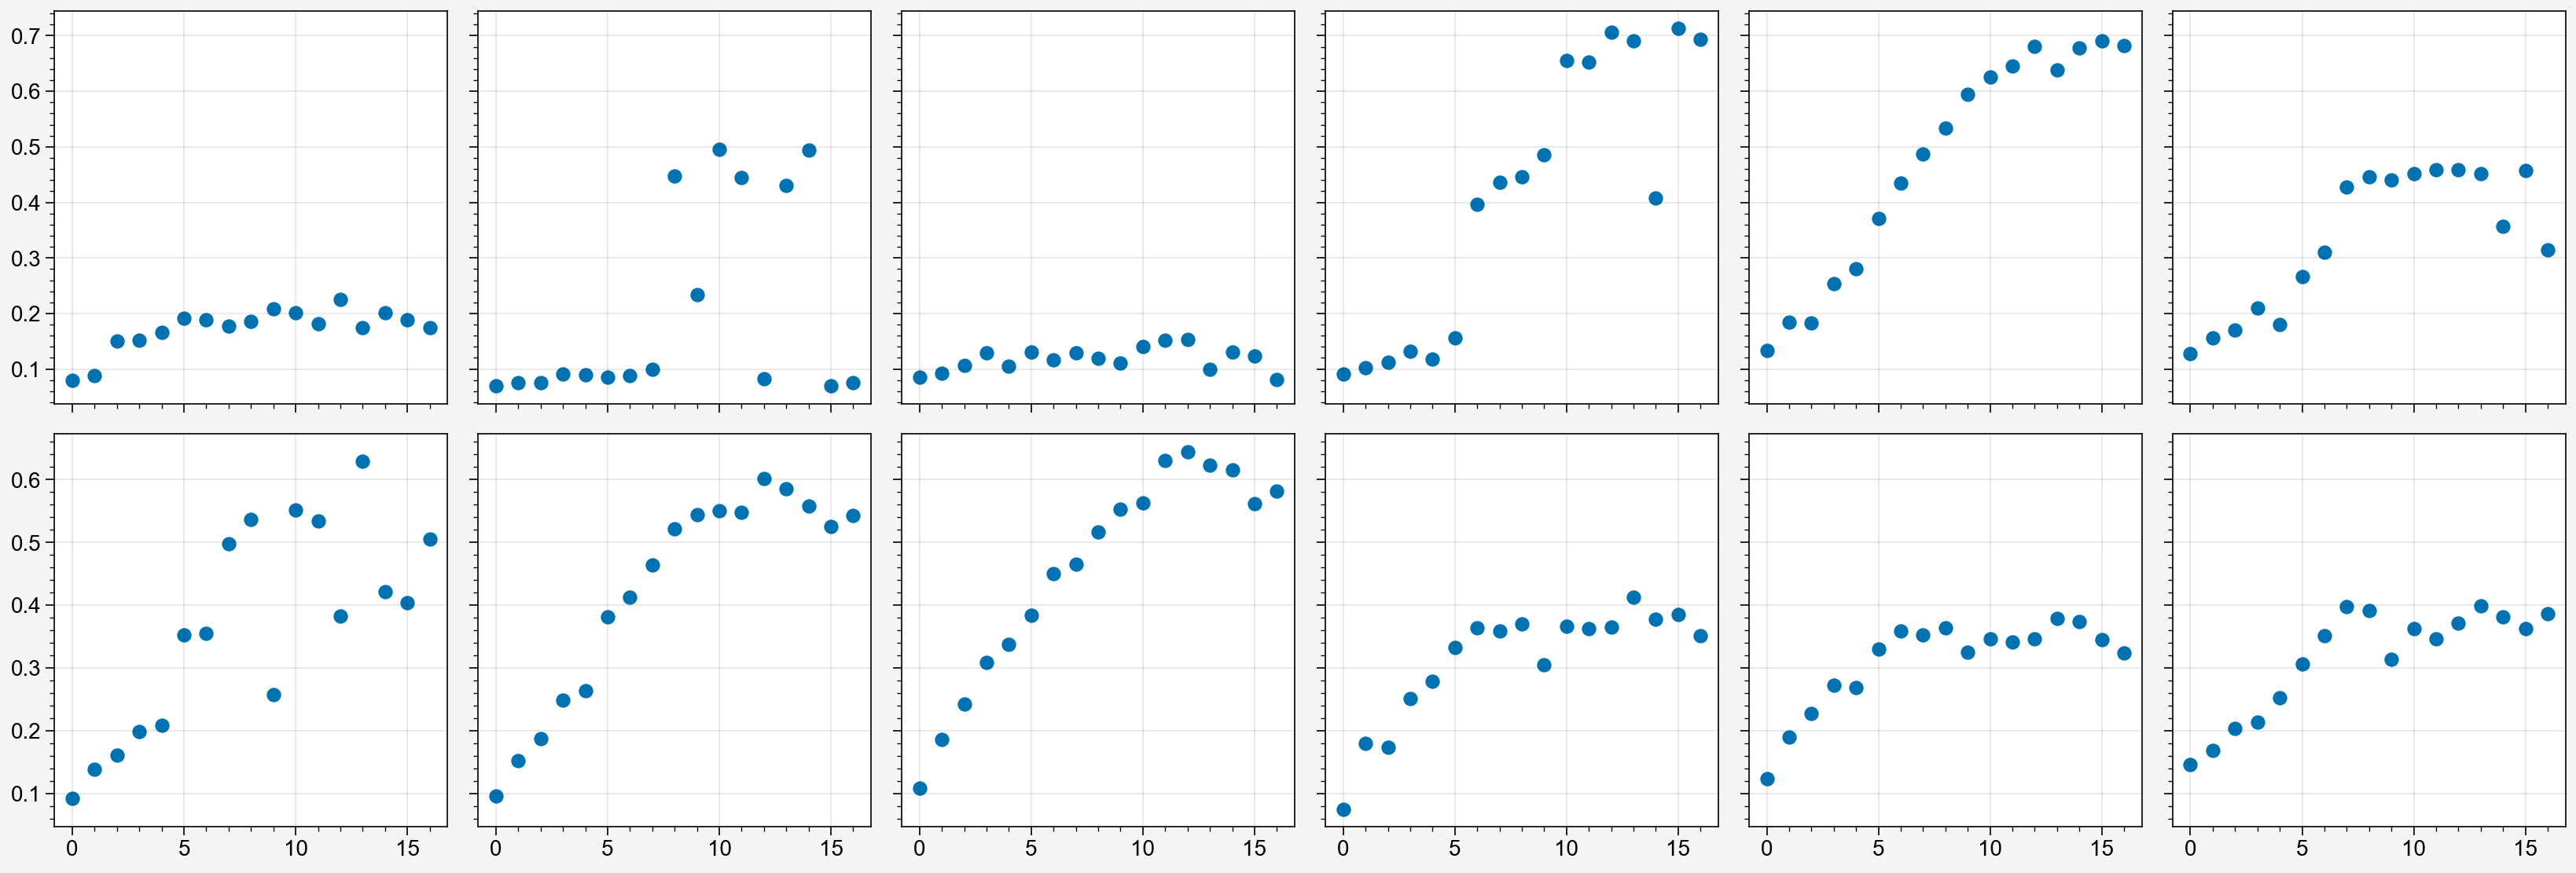

In [34]:
fig, ax = pplt.subplots(nrows=2, ncols=6)
for i, its in enumerate(all_its):
    ax[i].scatter(its)

# Generate indexes for agent checkpoints

On how long to reach 275 performance
- Showing reward info speeds up training
- Increased p slightly improves learning (although 1.5-1.7 seem more optimal than 2)

In [7]:
# Generate best agent indexes for later analysis

res = pickle.load(open('data/meta_representation_results2', 'rb'))
all_rew = res['rewards']
best_idxs = all_rew.sum(axis=(5, 6)).argmax(axis=-1)
pickle.dump(best_idxs, open('data/meta_representation_best_idxs', 'wb'))


# Generate agent indexes of first checkpoints to pass 275 requirement
rewsum = all_rew.sum(axis=(5, 6))
first_idxs = np.zeros(rewsum.shape, dtype='int')[:, :, :, :, 0]

minsum = 275 # total reward that 90% of agents achieve
for h in range(2):
    for i in range(4):
        for j in range(5):
            for t in range(10):
                r = rewsum[h, i, j, t]
                if (r > minsum).any():
                    first_idxs[h, i, j, t] = np.argmax(r > minsum)
                else:
                    first_idxs[h, i, j, t] = np.argmax(r)
pickle.dump(first_idxs, open('data/meta_representation_first_idxs', 'wb'))

# Generate agent indexes of checkpoints closest to 275 requirement
close_idxs = np.abs(rewsum - minsum).argmin(axis=-1)
pickle.dump(close_idxs, open('data/meta_representation_close_idxs', 'wb'))

In [9]:
%run bart_representation_analysis

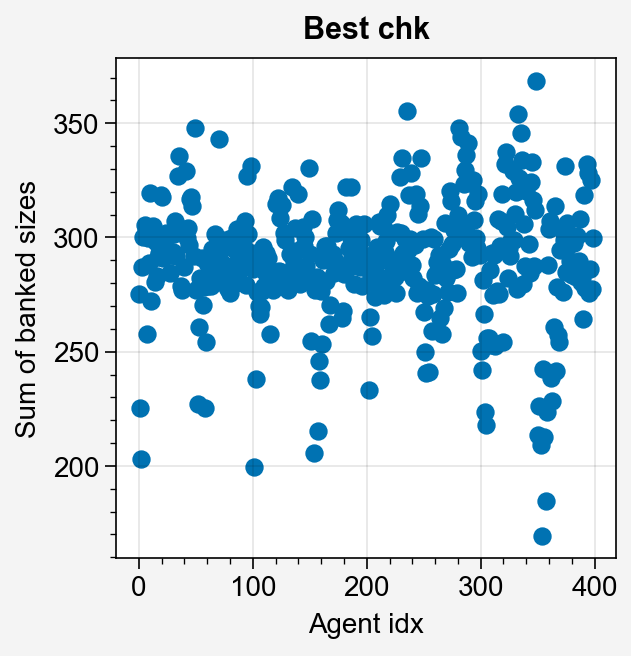

In [12]:
fig, ax = pplt.subplots()
ax[0].scatter(select_idxs(rewsum, 'best').flatten())

ax.format(xlabel='Agent idx', ylabel='Sum of banked sizes', 
          toplabels=['Best chk'])

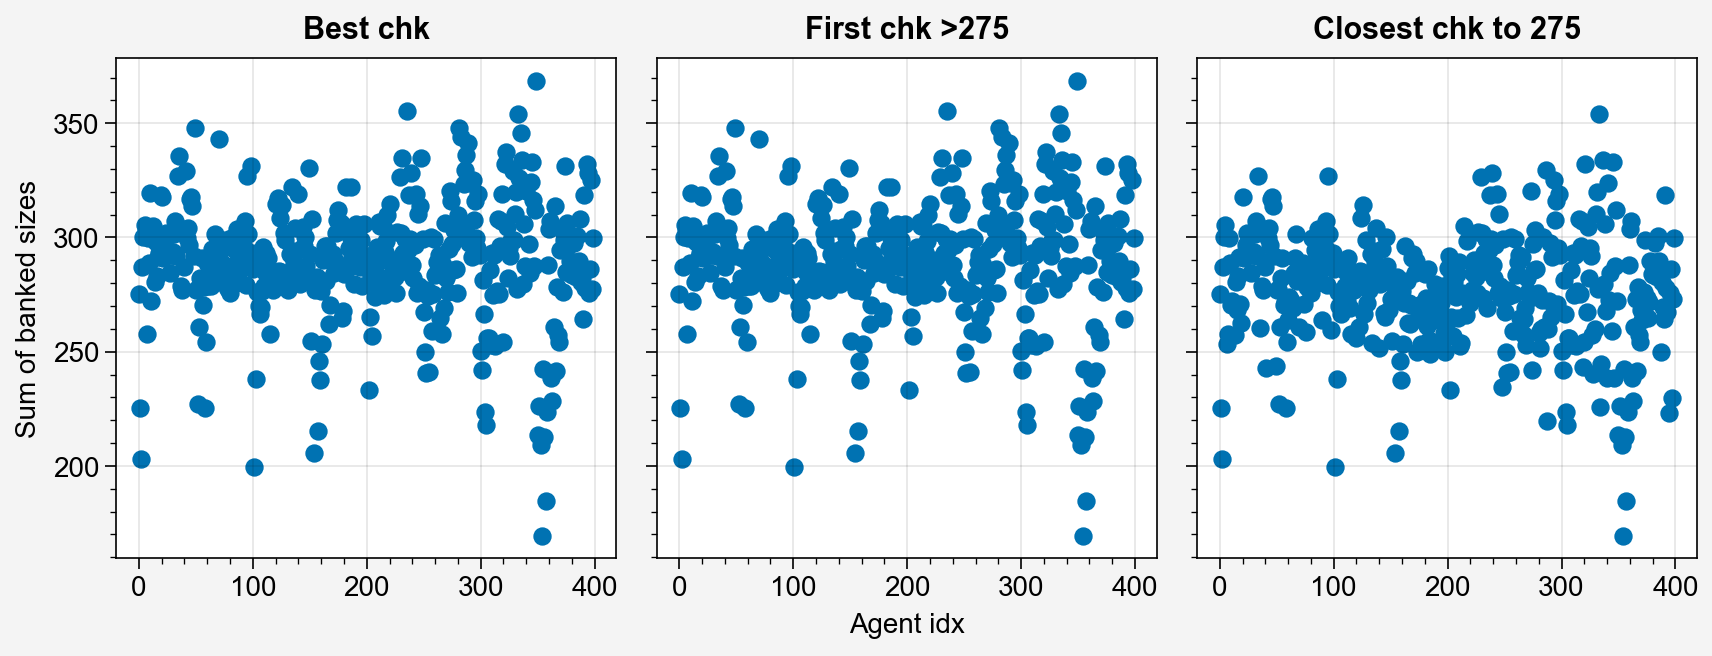

In [13]:
fig, ax = pplt.subplots(ncols=3)
ax[0].scatter(select_idxs(rewsum, 'best').flatten())
ax[1].scatter(select_idxs(rewsum, 'first').flatten())
ax[2].scatter(select_idxs(rewsum, 'close').flatten())

ax.format(xlabel='Agent idx', ylabel='Sum of banked sizes', 
          toplabels=['Best chk', 'First chk >275', 'Closest chk to 275'])

## Time to reach 275

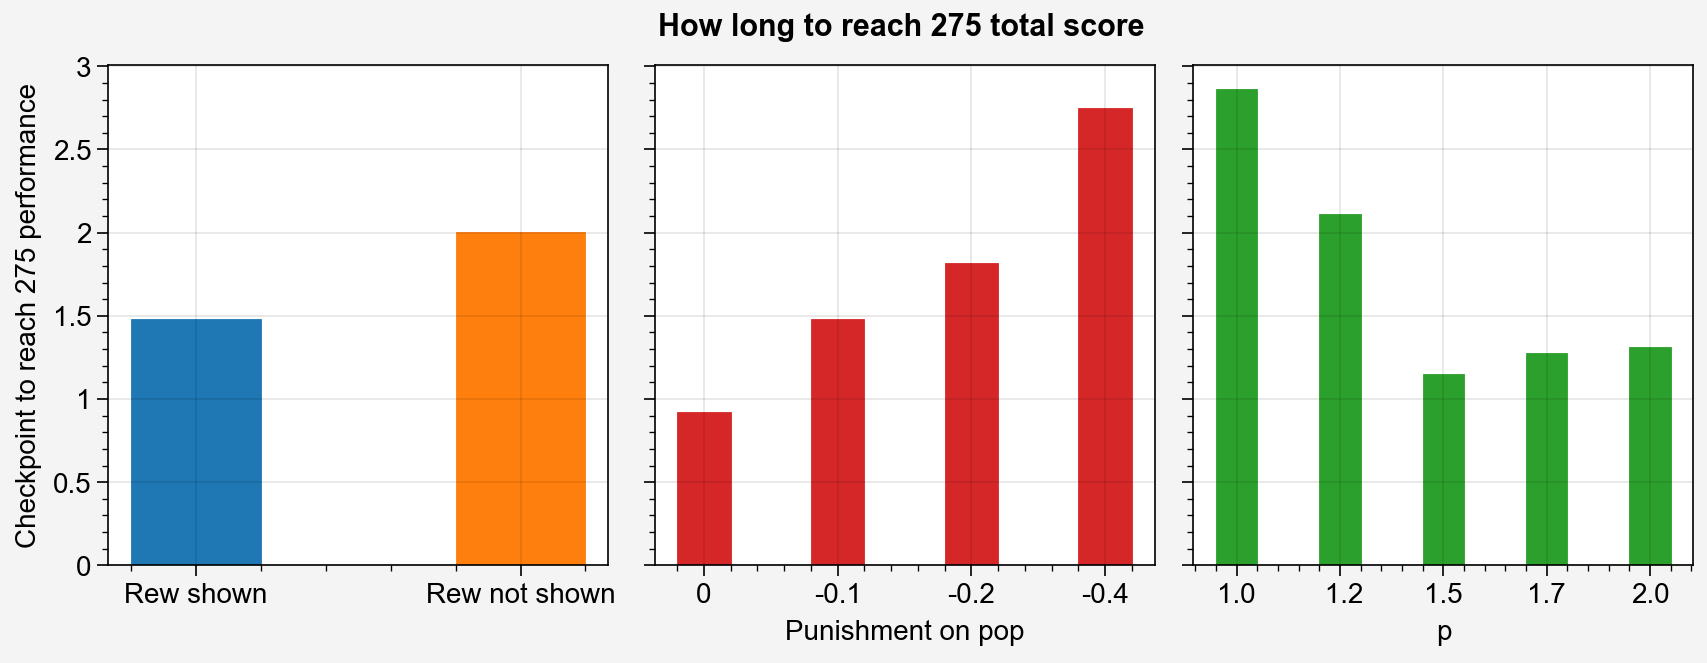

In [15]:
first_idxs = pickle.load(open('data/meta_representation_first_idxs', 'rb'))


give_labels = ['Rew shown', 'Rew not shown']
pop_labels = ['0', '-0.1', '-0.2', '-0.4']
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
pop_axis = 'Punishment on pop'
p_axis = 'p'

fig, ax = pplt.subplots(ncols=3, sharex=False)
for i in range(2):
    s = len(first_idxs[i].reshape(-1))
    # ax[0].boxplot(i, first_idxs[i].reshape(-1))
    # ax[0].scatter(s*[i], first_idxs[i].reshape(-1))
    ax[0].bar([i], first_idxs[i].reshape(-1).mean(), c=rgb_colors[i])
    ax[0].format(xlocator=range(2), xformatter=give_labels)
for i in range(4):
    s = len(first_idxs[:, i].reshape(-1))
    # ax[1].boxplot(i, first_idxs[:, i].reshape(-1))
    # ax[1].scatter(s*[i], first_idxs[:, i].reshape(-1))
    ax[1].bar([i], first_idxs[:, i].reshape(-1).mean(), c=rgb_colors[3])
    ax[1].format(xlocator=range(6), xformatter=pop_labels, xlabel=pop_axis)
for i in range(5):
    s = len(first_idxs[:, :, i].reshape(-1))
    # ax[2].boxplot(i, first_idxs[:, :, i].reshape(-1))
    # ax[2].scatter(s*[i], first_idxs[:, :, i].reshape(-1))
    ax[2].bar([i], first_idxs[:, :, i].reshape(-1).mean(), c=rgb_colors[2])
    ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

ax.format(ylabel='Checkpoint to reach 275 performance',
          suptitle='How long to reach 275 total score')

# General performance measures

In [17]:
res = pickle.load(open('data/meta_representation_results2', 'rb'))

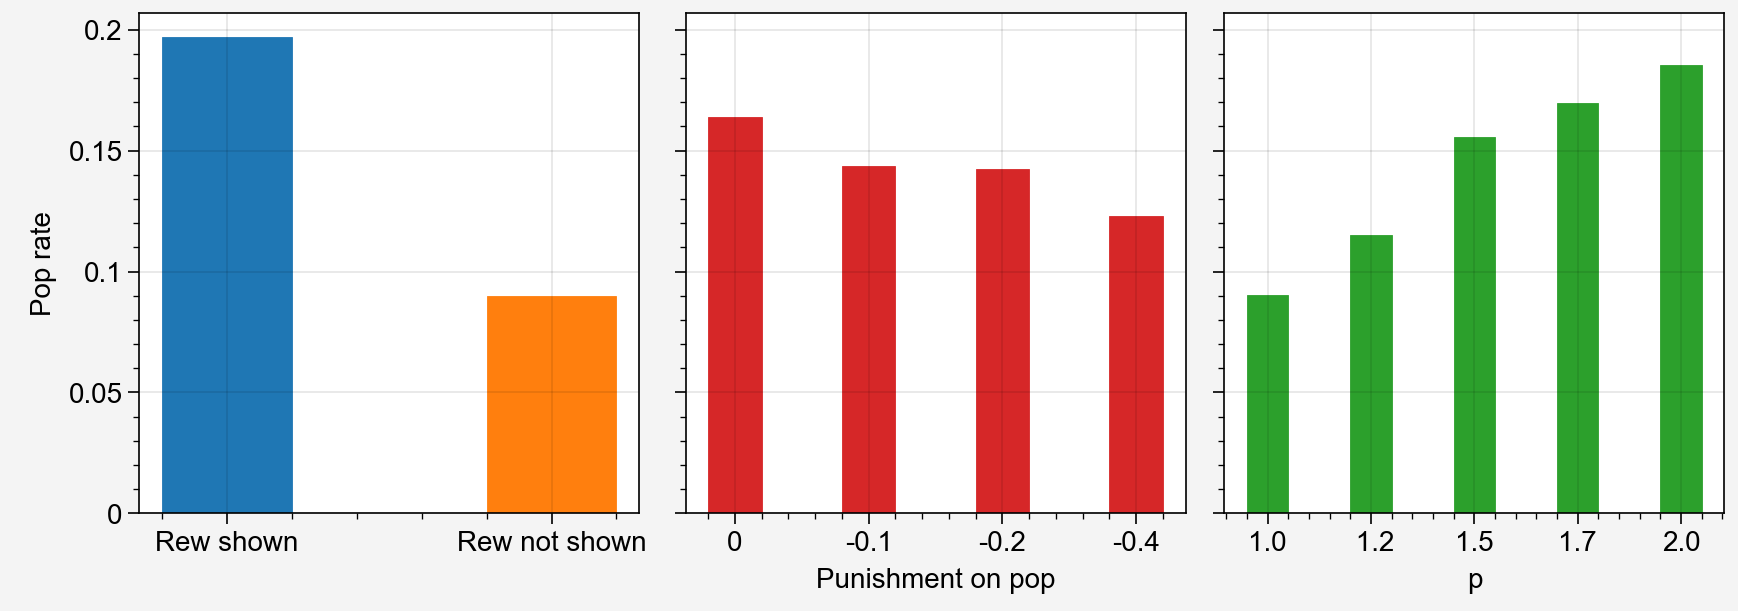

In [20]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[0].bar(h, np.mean(pop_rates), c=rgb_colors[h])
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[1].bar(i, np.mean(pop_rates), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[2].bar(j, np.mean(pop_rates), c=rgb_colors[2])

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Pop rate')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)
    

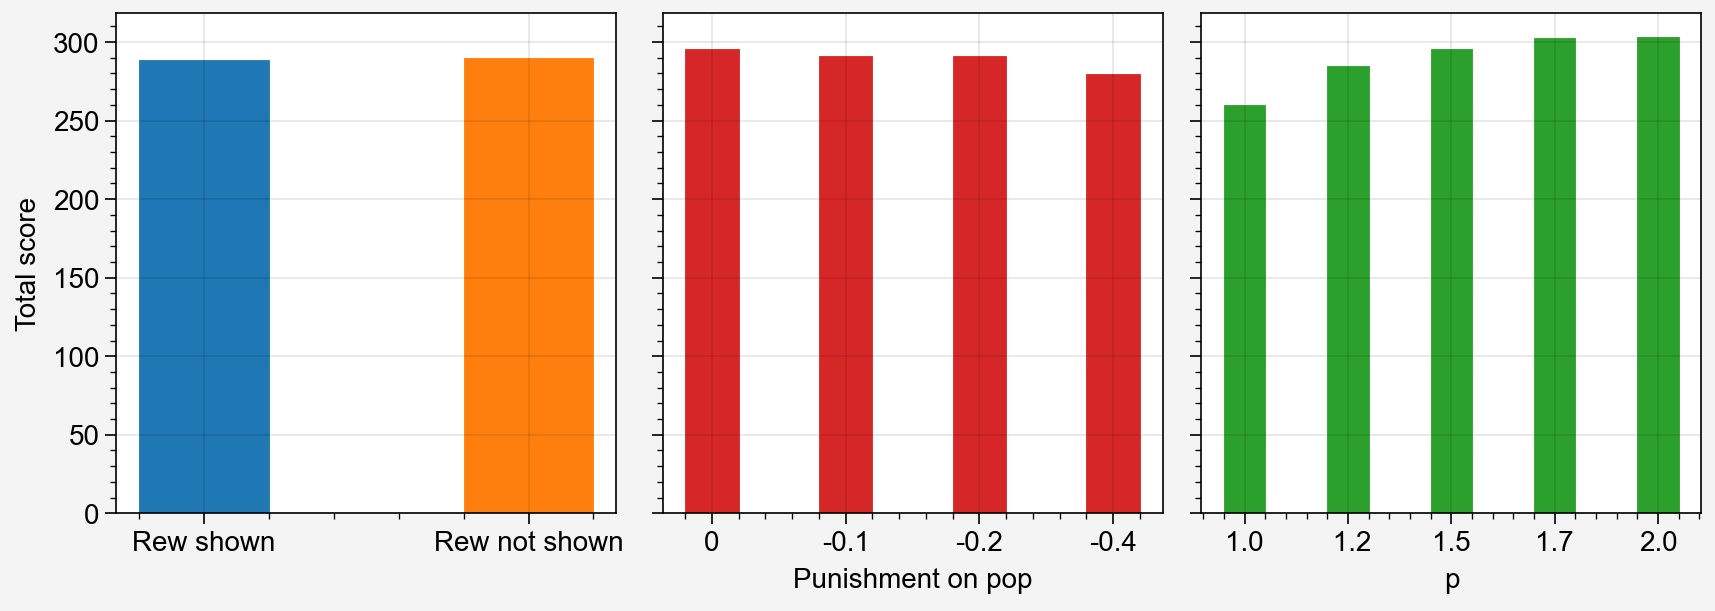

In [22]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['last_sizes'][idx].sum())
    ax[0].bar(h, np.mean(pop_rates), c=rgb_colors[h])
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['last_sizes'][idx].sum())
    ax[1].bar(i, np.mean(pop_rates), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['last_sizes'][idx].sum())
    ax[2].bar(j, np.mean(pop_rates), c=rgb_colors[2])

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Total score')
ax[1].format(xlocator=range(6), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)
    

# Rewards for best agents

Possible the more accurate version of performance can be found by looking at the best performance reached by each agent across checkpoints. Performance here is measured purely based on the total size of balloons banked, without any $p$ or pop considerations

- No clear trend across punishments on performance
- No significant difference in performance 
- Clear increase to rewards as $p$ increases

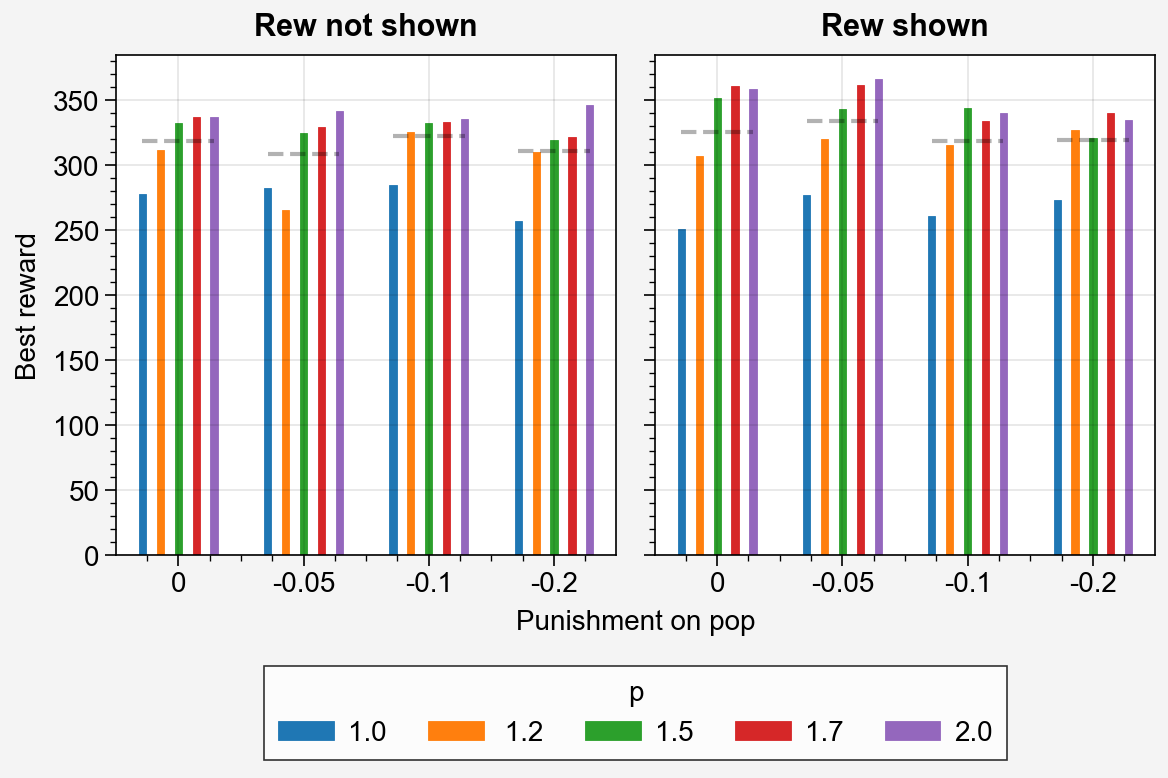

In [140]:
all_rew = res['rewards']
fig, ax = pplt.subplots(ncols=2)

for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = all_rew[h, i, j].sum(axis=(2, 3)).max(axis=1).mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
            
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+4], [y, y], c='black', ls='--', alpha=0.3)

ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Best reward')
fig.legend(bars, loc='b', ncols=5, title='p')
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

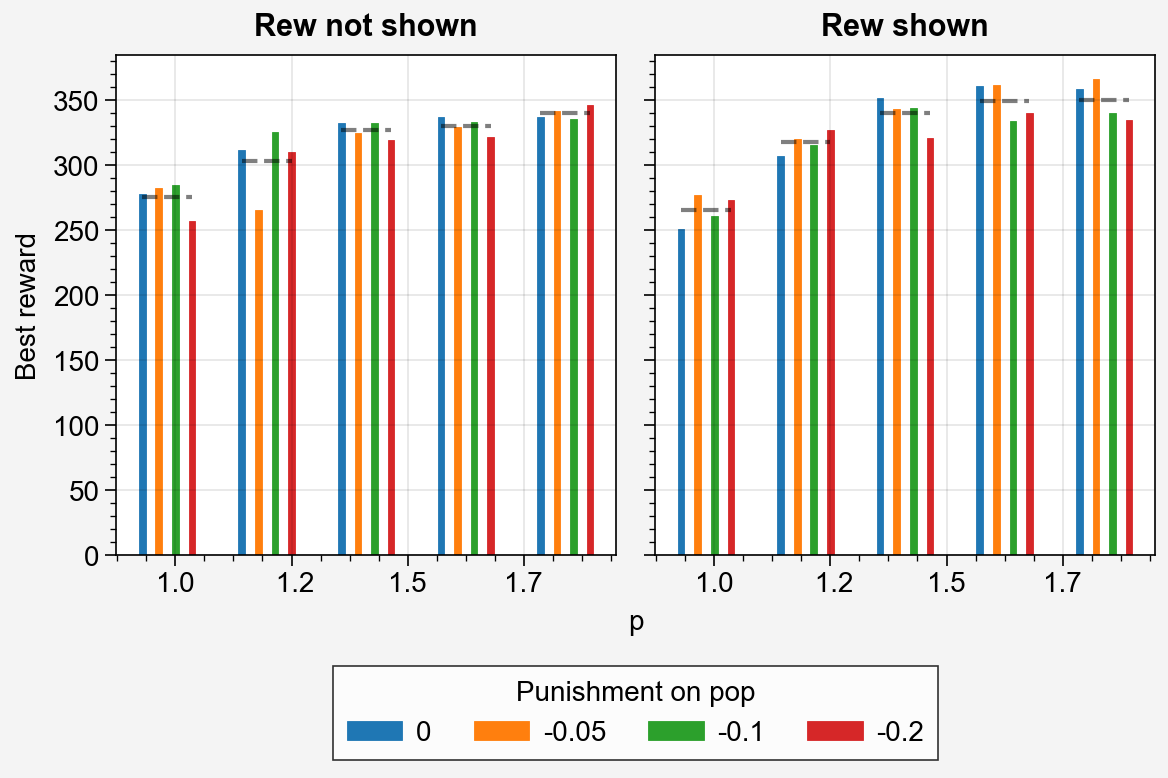

In [159]:
rew = res['rewards'].sum(axis=-1)
rew = rew.sum(axis=-1)

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = all_rew[h, i, j].sum(axis=(2, 3)).max(axis=1).mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)

        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=p_labels,
          xlabel=p_axis, ylabel='Best reward')
fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

p-value: 0.1808


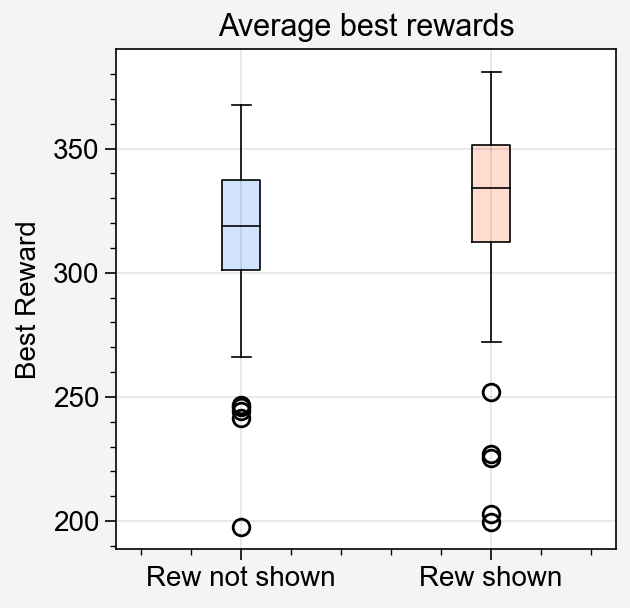

In [155]:
all_rew = res['rewards']
fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = all_rew[h].sum(axis=(4, 5)).max(axis=-1).flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best Reward',
          title='Average best rewards')

p-value: 0.5369


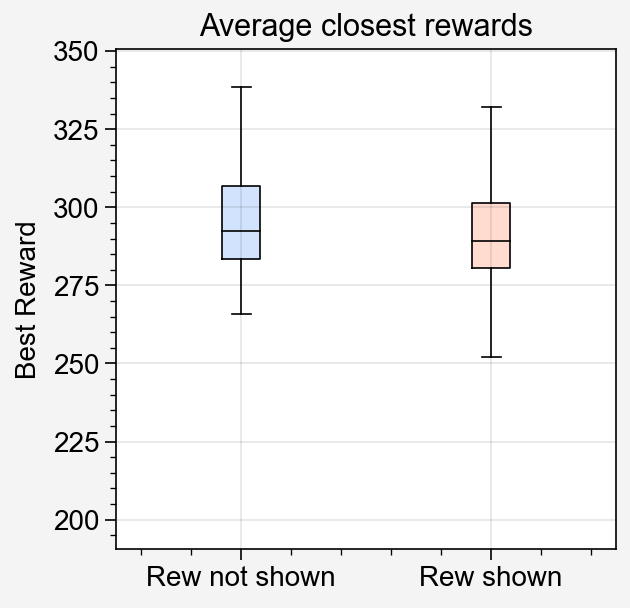

In [21]:
all_rew = res['rewards'].sum(axis=(5, 6))
all_rew = select_idxs(all_rew, 'first')
fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = all_rew[h].reshape(-1)
    ax.boxplot(h, y, cycle=rgb_colors[h], fliers=False)
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best Reward',
          title='Average closest rewards')

p-value: 0.0027


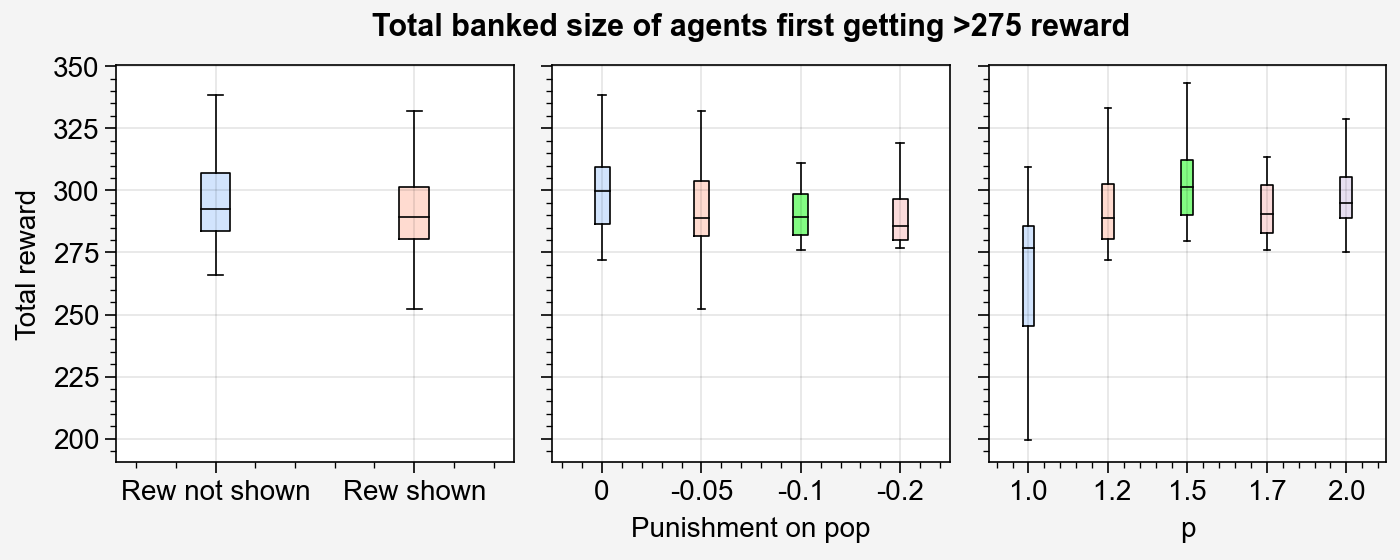

In [37]:
all_rew = res['rewards'].sum(axis=(5, 6))
all_rew = select_idxs(all_rew, 'first')
fig, ax = pplt.subplots(ncols=3, figwidth=7, sharex=False)

ys = []
for h in range(2):
    y = all_rew[h].reshape(-1)
    ax[0].boxplot(h, y, cycle=rgb_colors[h], fliers=False)
    ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Total reward')
    ys.append(y)
for i in range(4):
    y = all_rew[:, i].reshape(-1)
    ax[1].boxplot(i, y, cycle=rgb_colors[i], fliers=False)
    ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
                 ylabel='Total reward')
    ys.append(y)
for j in range(5):
    y = all_rew[:, :, j].reshape(-1)
    ax[2].boxplot(j, y, cycle=rgb_colors[j], fliers=False)
    ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
                 ylabel='Total reward')
    ys.append(y)
    
ax.format(suptitle='Total banked size of agents first getting >275 reward')
print(f'p-value: {ttest_ind(ys[6], ys[7]).pvalue:.4f}')

## Pop rates for best agents

Taking the best agents as we did in the previous section, we can now look at the best agents from each of these. Some more clear trends
- Punishment does not have significant trend effect on pop rate
- Increased $p$ increases pop rates (makes sense, as the agents are incentivized to push balloons larger)
- Showing reward in the observation actually seems to increase pop rate, which may be related to the agents pushing balloons a bit larger when rewards are shown

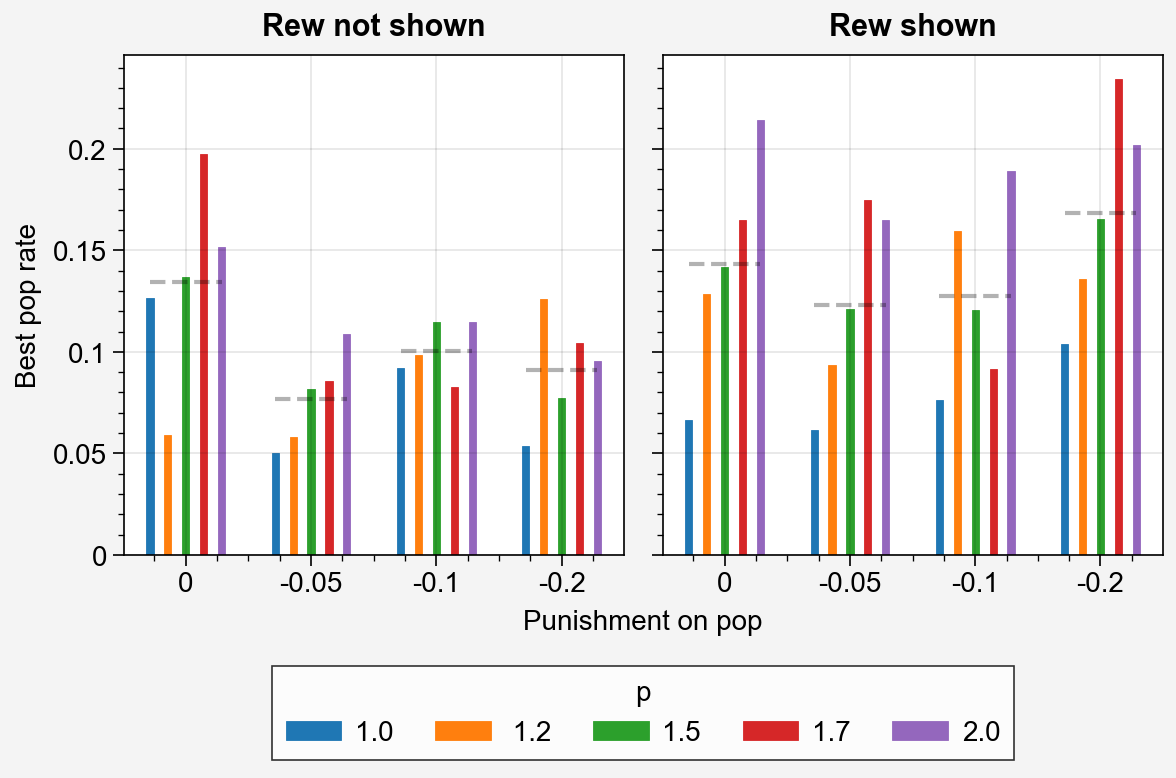

In [14]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates)

fig, ax = pplt.subplots(ncols=2)

for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = pop_rates[h, i, j].mean(axis=-1)
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
            
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+4], [y, y], c='black', ls='--', alpha=0.3)

ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Best pop rate')
fig.legend(bars, loc='b', ncols=5, title='p')
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

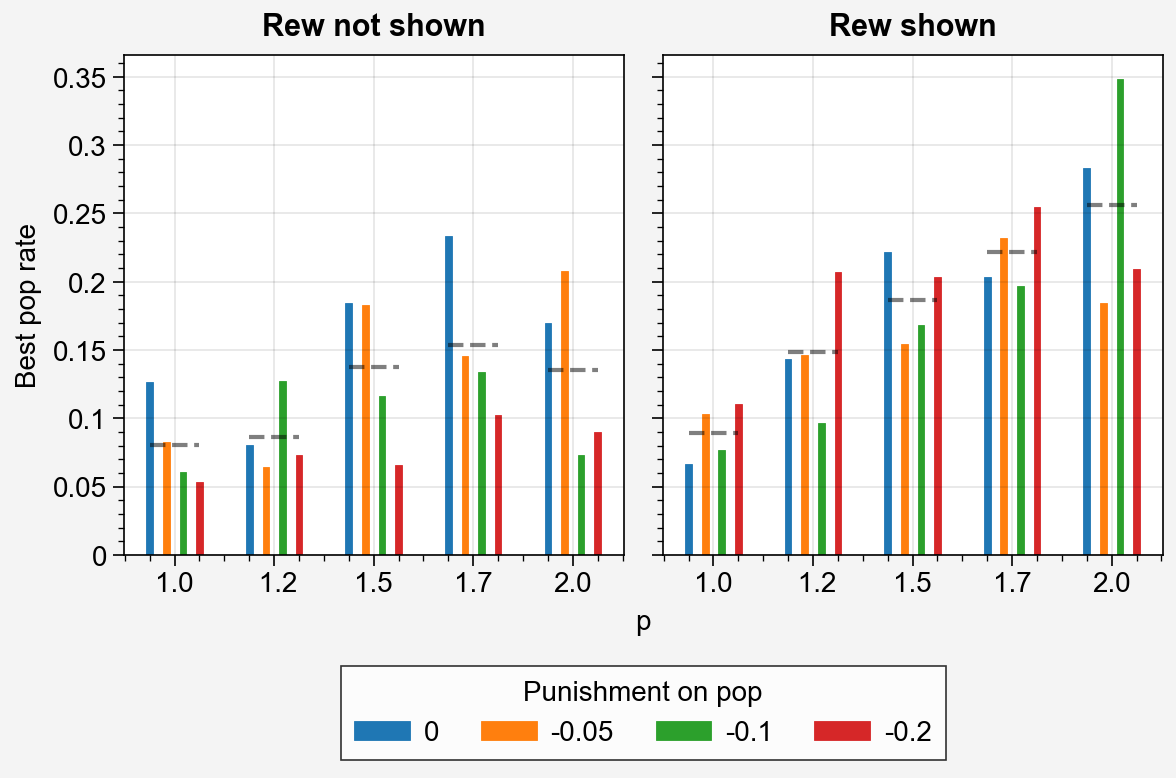

In [15]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = pop_rates[h, i, j].mean(axis=-1)
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)

        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=np.arange(5)*6+1.5, xformatter=p_labels,
          xlabel=p_axis, ylabel='Best pop rate')
fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

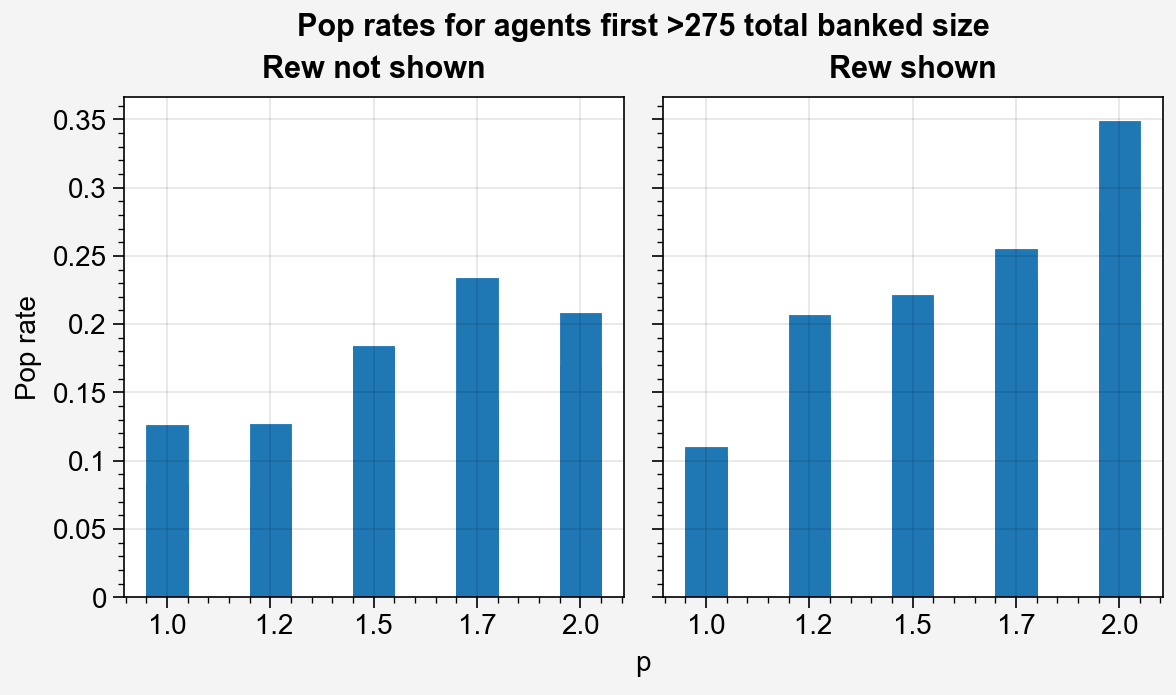

In [39]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    bars = []
    ys = []
    for j in range(len(p_labels)):
        x = j
        y = pop_rates[h, :, j].mean(axis=-1)
        bars.append(ax[h].bar(x, y, c=rgb_colors[0], label=pop_labels[i]))
        ys.append(y)

        y = np.mean(ys)
        # ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=range(5), xformatter=p_labels,
          xlabel=p_axis, ylabel='Pop rate', suptitle='Pop rates for agents first >275 total banked size')
# fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

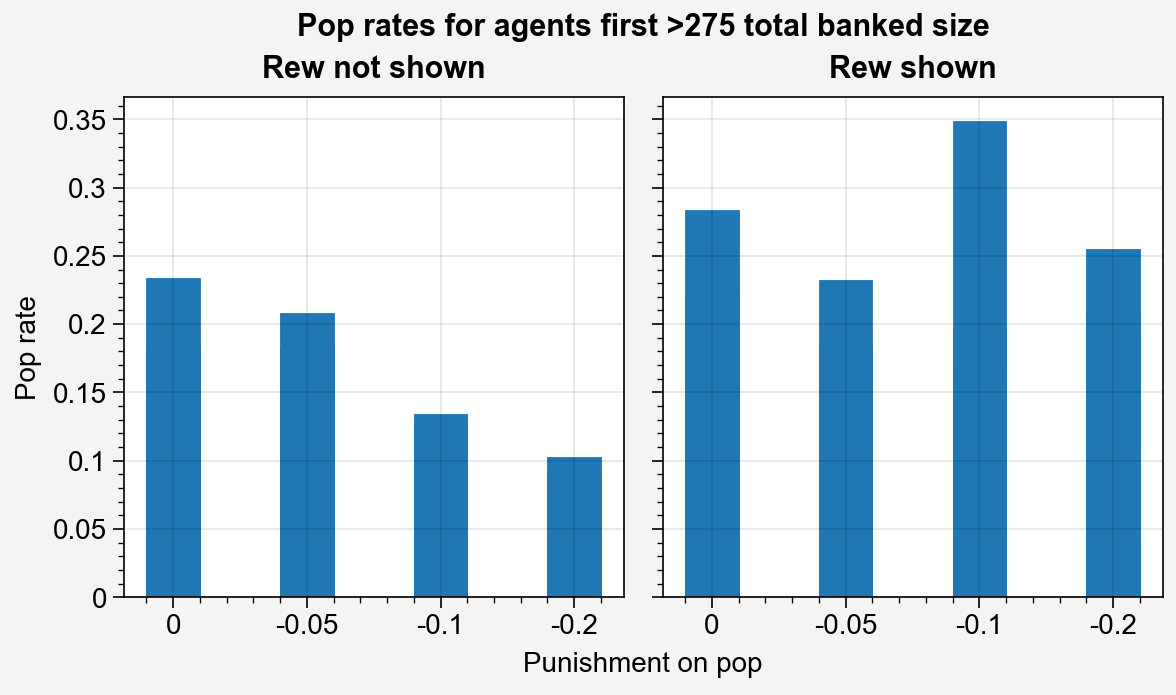

In [40]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    bars = []
    ys = []
    for j in range(len(pop_labels)):
        x = j
        y = pop_rates[h, j, :].mean(axis=-1)
        bars.append(ax[h].bar(x, y, c=rgb_colors[0], label=pop_labels[i]))
        ys.append(y)

        y = np.mean(ys)
        # ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=range(4), xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Pop rate', suptitle='Pop rates for agents first >275 total banked size')
# fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

p-value: 0.0002


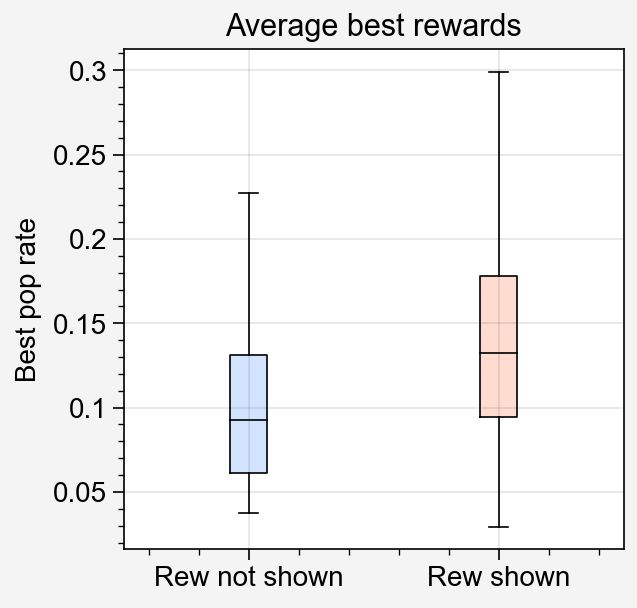

In [21]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates)

fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = pop_rates[h].flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best pop rate',
          title='Average best rewards')

p-value: 0.000038


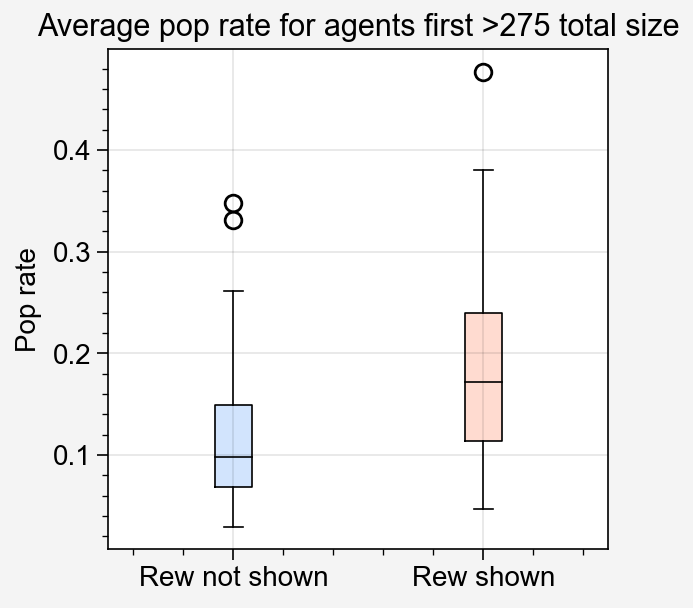

In [43]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = pop_rates[h].flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.6f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Pop rate',
          title='Average pop rate for agents first >275 total size')

# Rewards over training

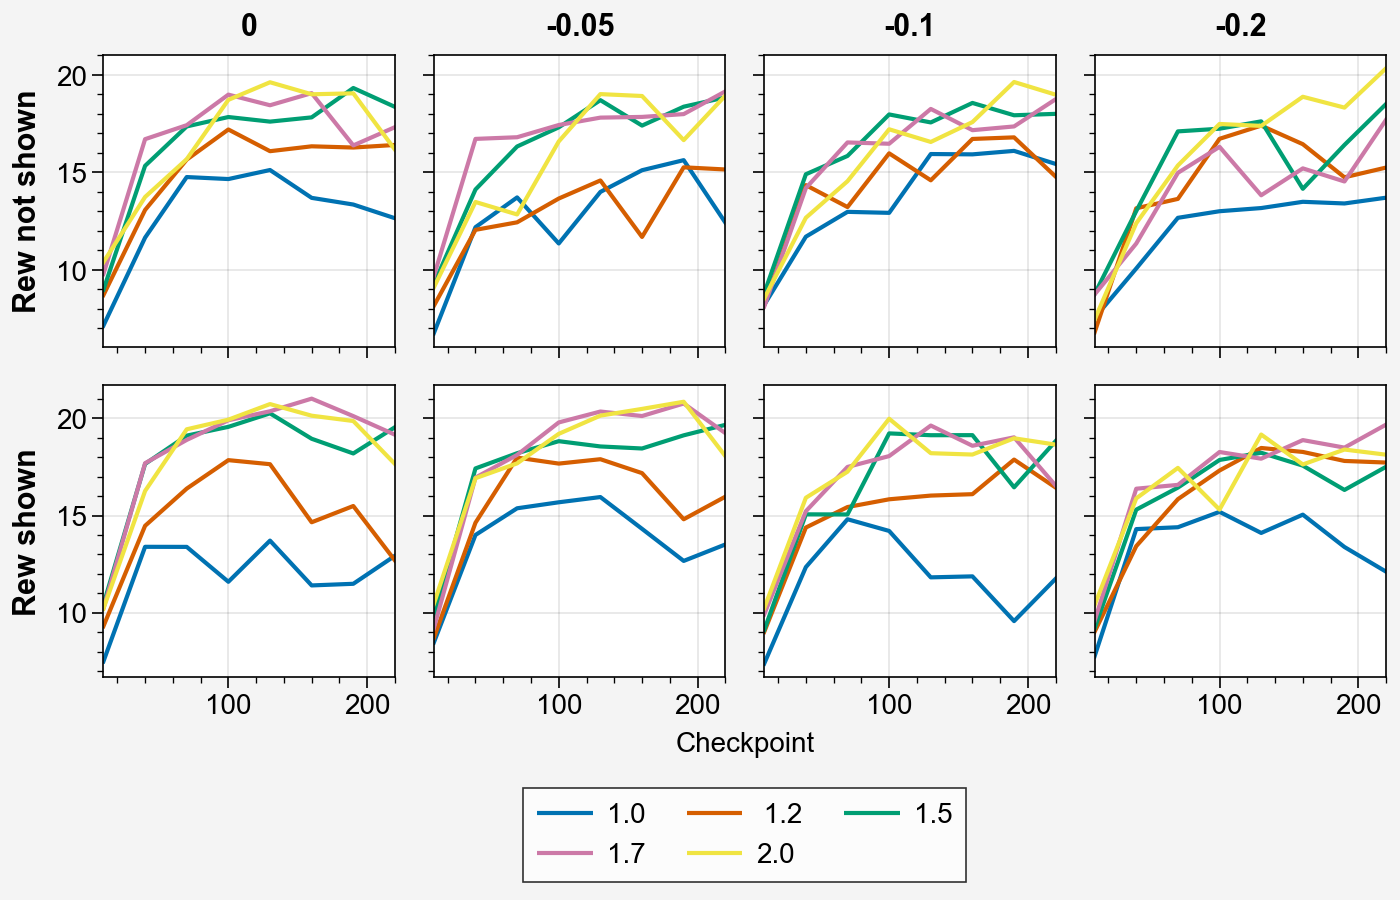

In [28]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        r = all_rew[h, i].sum(axis=4).mean(axis=(1, 3))
        lines = ax[h, i].plot(chks, r.T, label=p_labels)
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels)
        

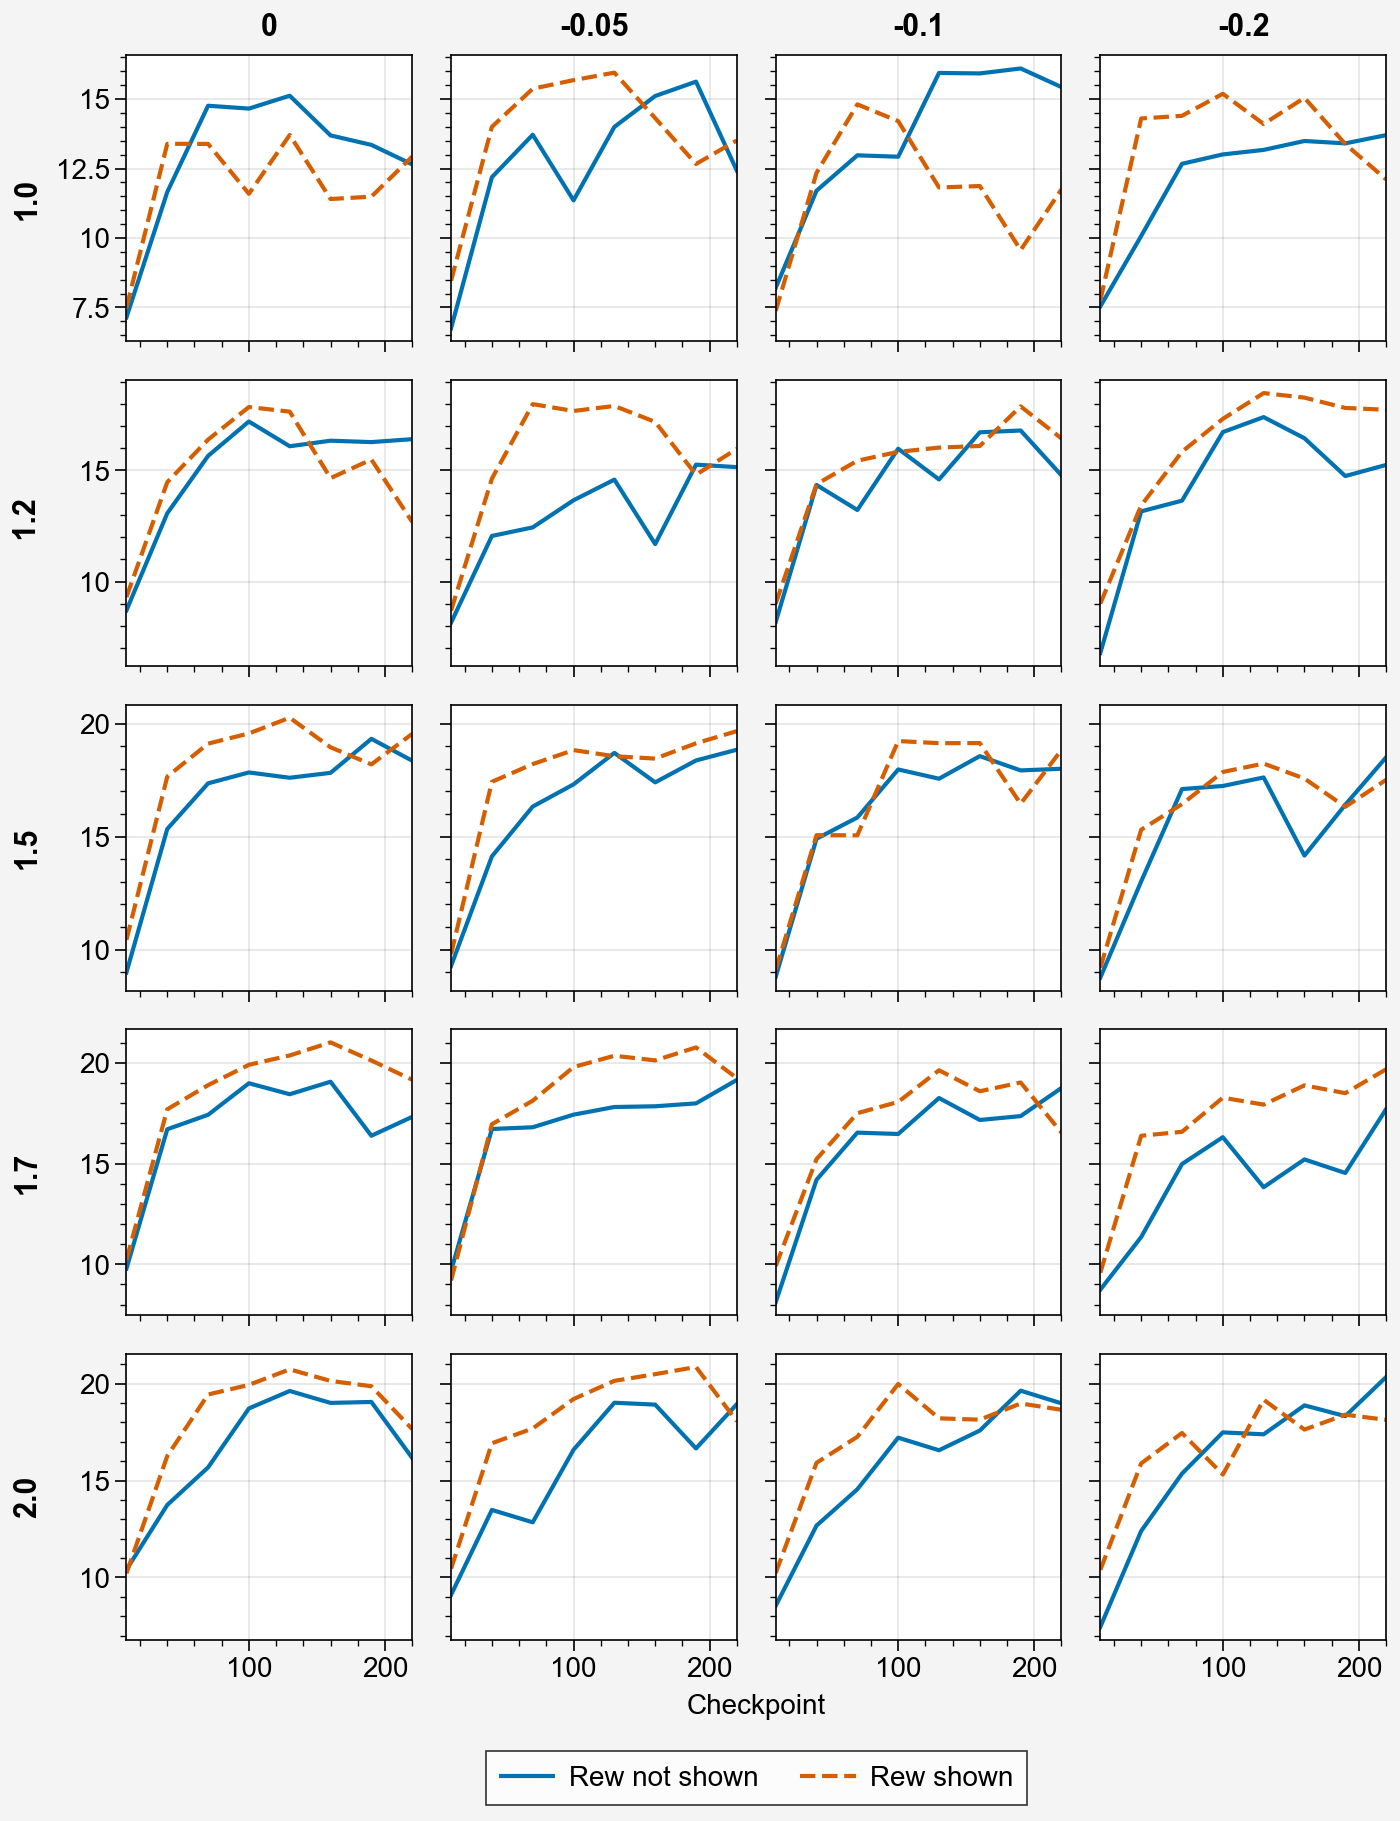

In [30]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = all_rew[:, i, j].sum(axis=4).mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Pop rates

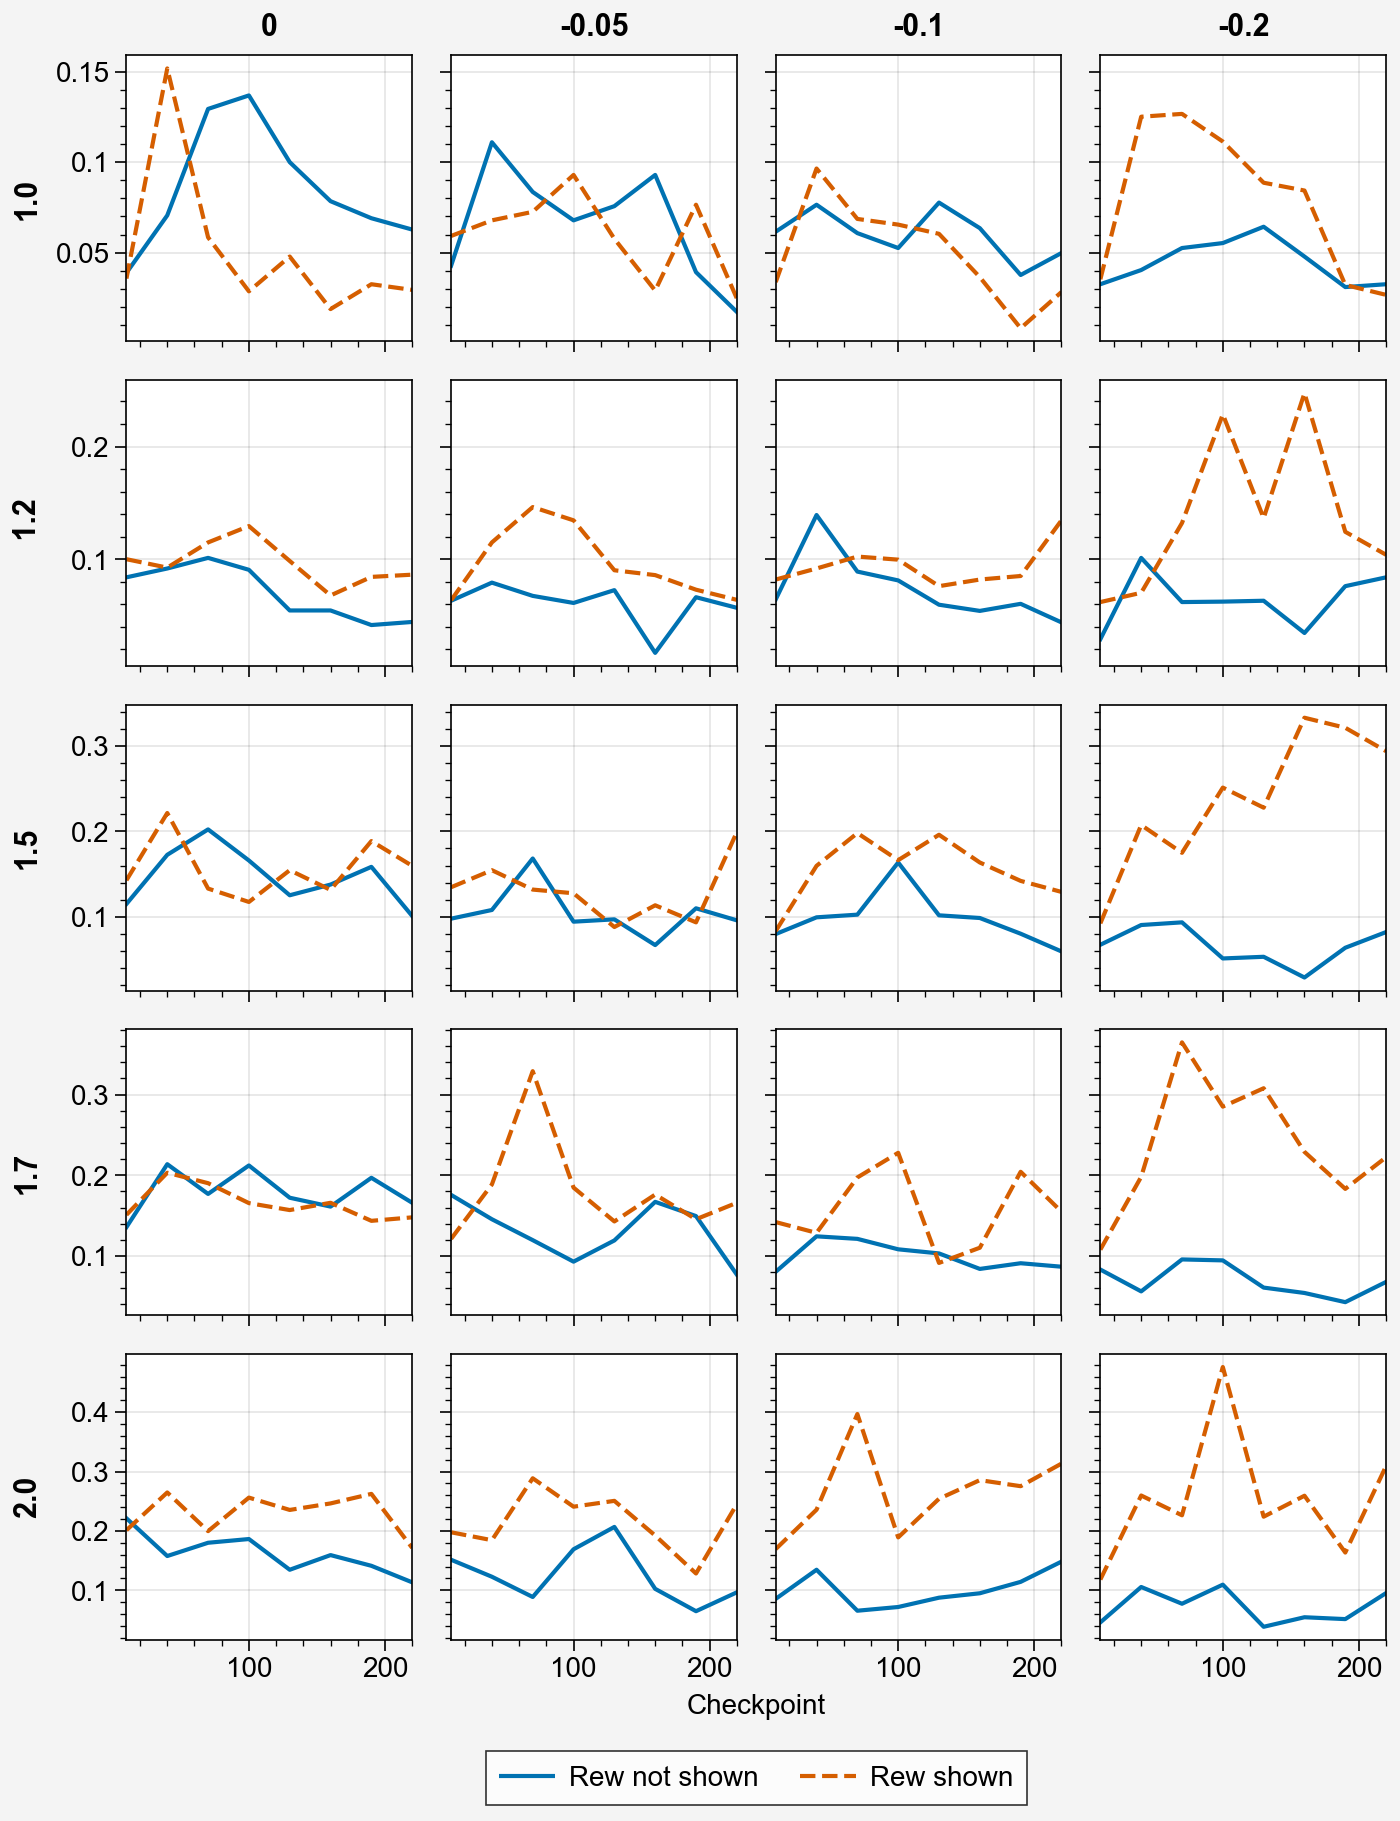

In [66]:
# True rewards

pop_rates = res['pop_rate']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Variation rewards

The rewards that the agent actually earns under their own training conditions

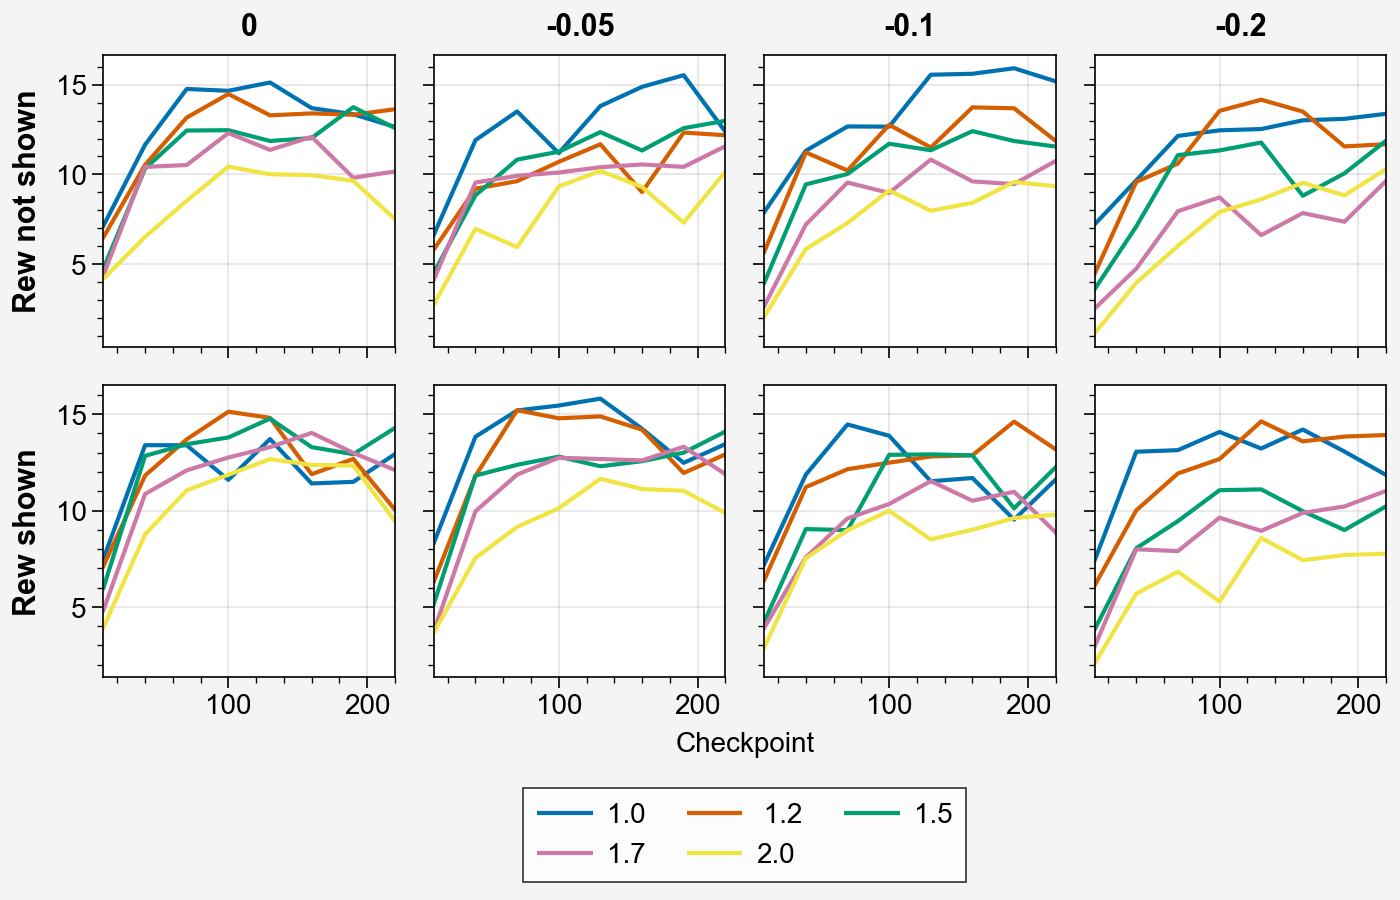

In [67]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']
all_pops = res['pop_rate']
all_num_balloons = res['all_num_balloons']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        lines = []
        pun = pop_vals[i]
        for j, p in enumerate(models):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.mean(axis=(0, 2))
            lines.append(ax[h, i].plot(chks, true_r, label=p_labels[j]))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels)


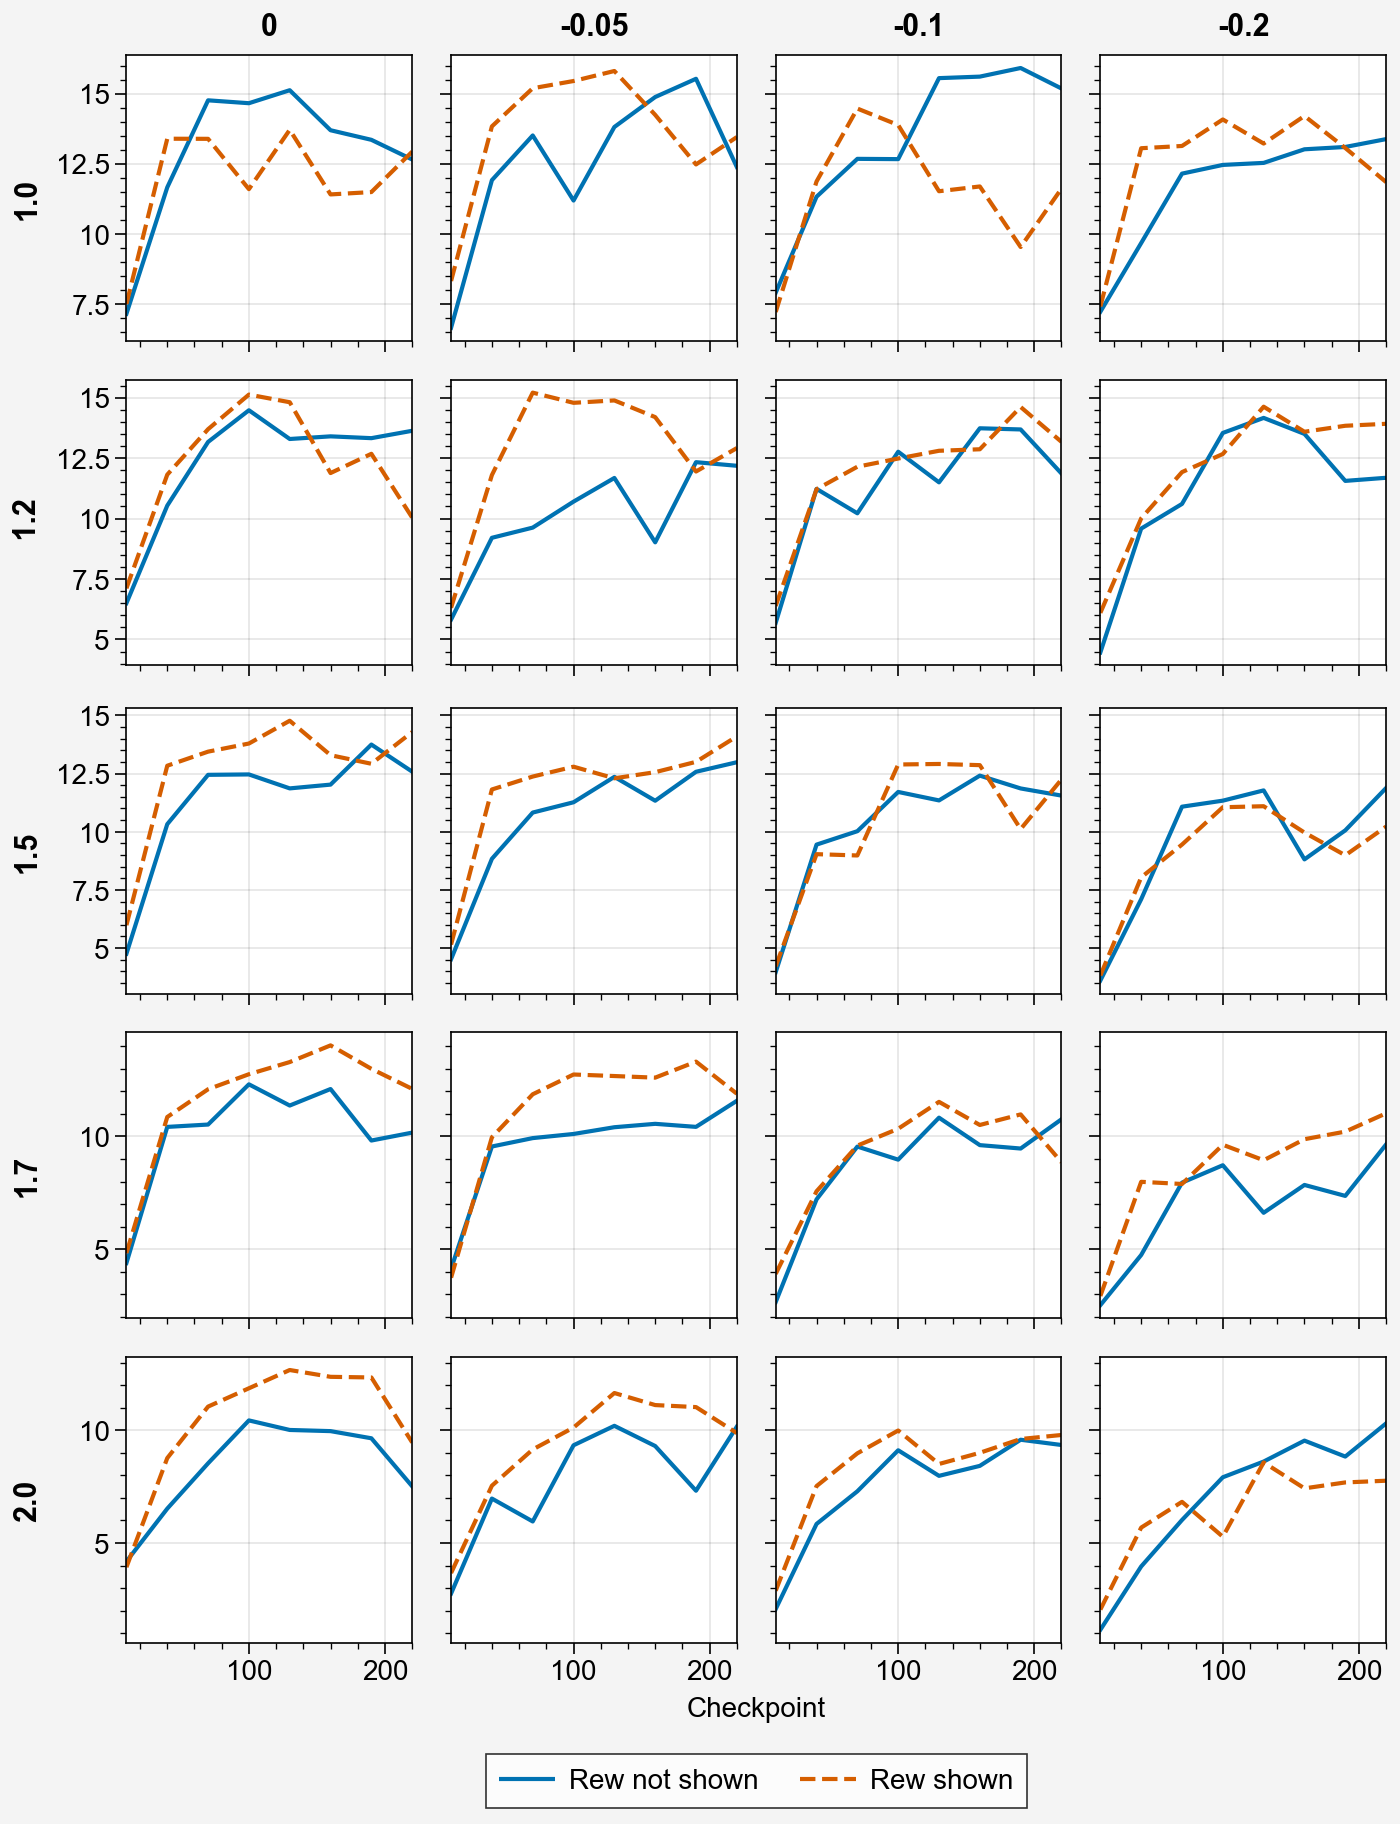

In [68]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']
all_pops = res['pop_rate']
all_num_balloons = res['all_num_balloons']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        pun = pop_vals[i]
        p = models[j]
        for h in range(2):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.mean(axis=(0, 2))
            ls = '-' if h == 0 else '--'
            lines.append(ax[j, i].plot(chks, true_r, label=give_labels[h],
                                       ls=ls))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Pushed sizes

The sizes that agents push balloons to regardless of whether the balloon popped or not

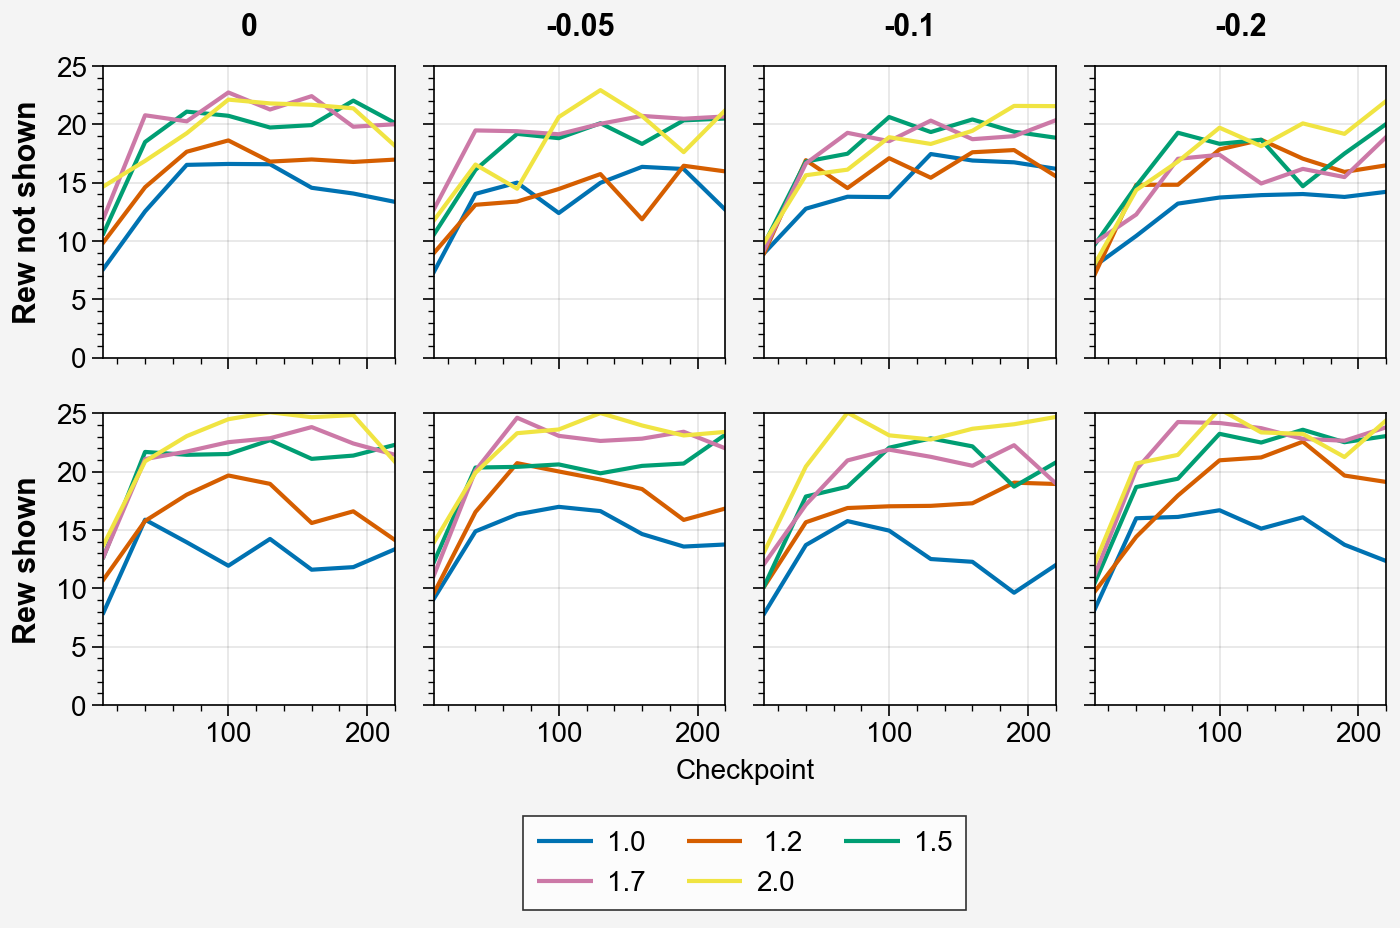

In [121]:
# True rewards

unpopped_sizes = res['unpopped_sizes']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        r = unpopped_sizes[h, i].sum(axis=4).mean(axis=(1, 3))
        lines = ax[h, i].plot(chks, r.T, label=p_labels)
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels,
          ylim=[0, 25])
        

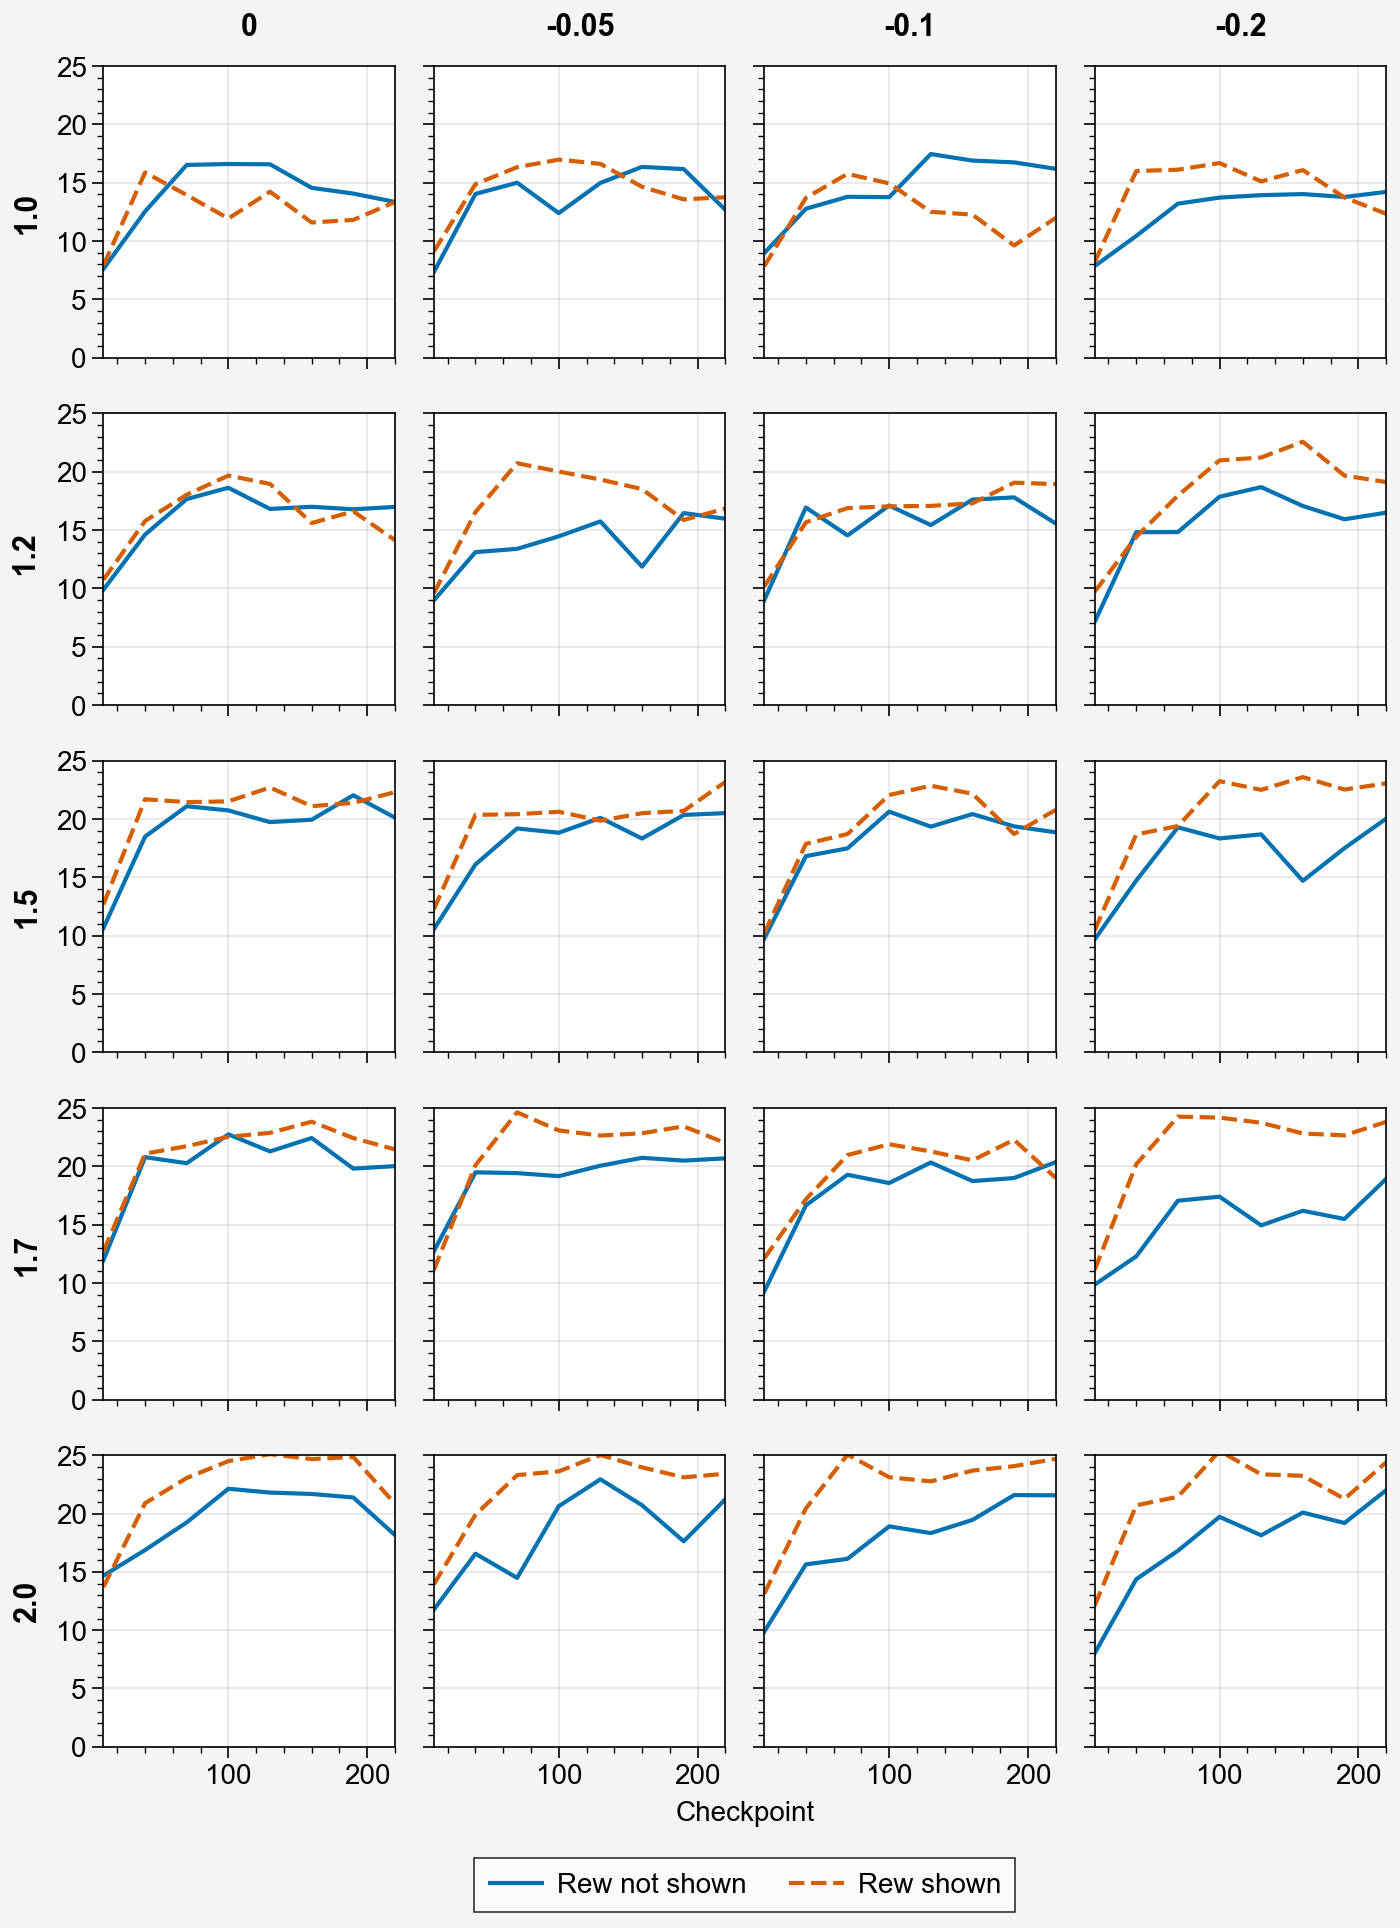

In [120]:
# True rewards

all_unpopped = res['unpopped_sizes']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = all_unpopped[:, i, j].sum(axis=4).mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels, 
          ylim=[0, 25])
        

# Find first performant checkpoint for each agent

Pretty clearly here, we can see that despite the agents achieving less true reward (the $r=s^p$ adjusted rewards with pops included) as p is increased, they achieve the same or more banked balloon rewards

If we want to find the agents that just pass a minimum score without worrying more about further skill, we can look for agents with a total >275 banked balloon size across thhe 17 episodes, which 90% of agents tested achieve at some point in the tested checkpoints

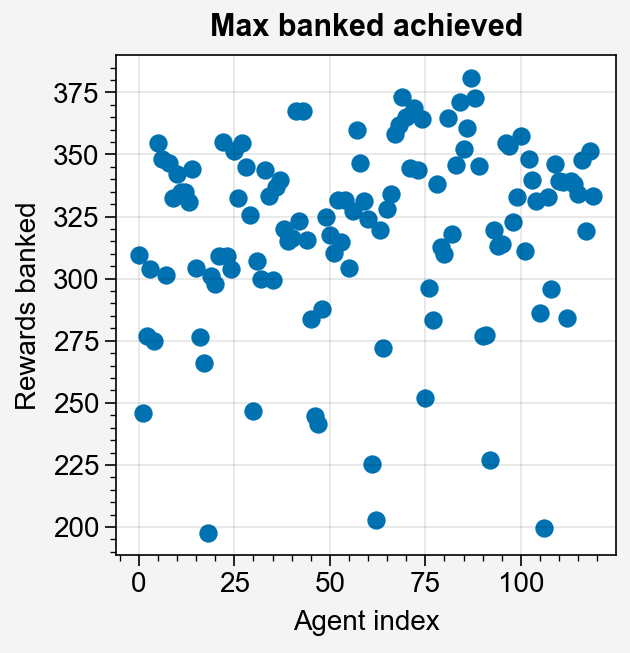

In [117]:
rew = res['rewards'].sum(axis=-1)
rew = rew.sum(axis=-1)
fig, ax = pplt.subplots()
ax.scatter(rew.max(axis=-1).reshape(-1))
ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

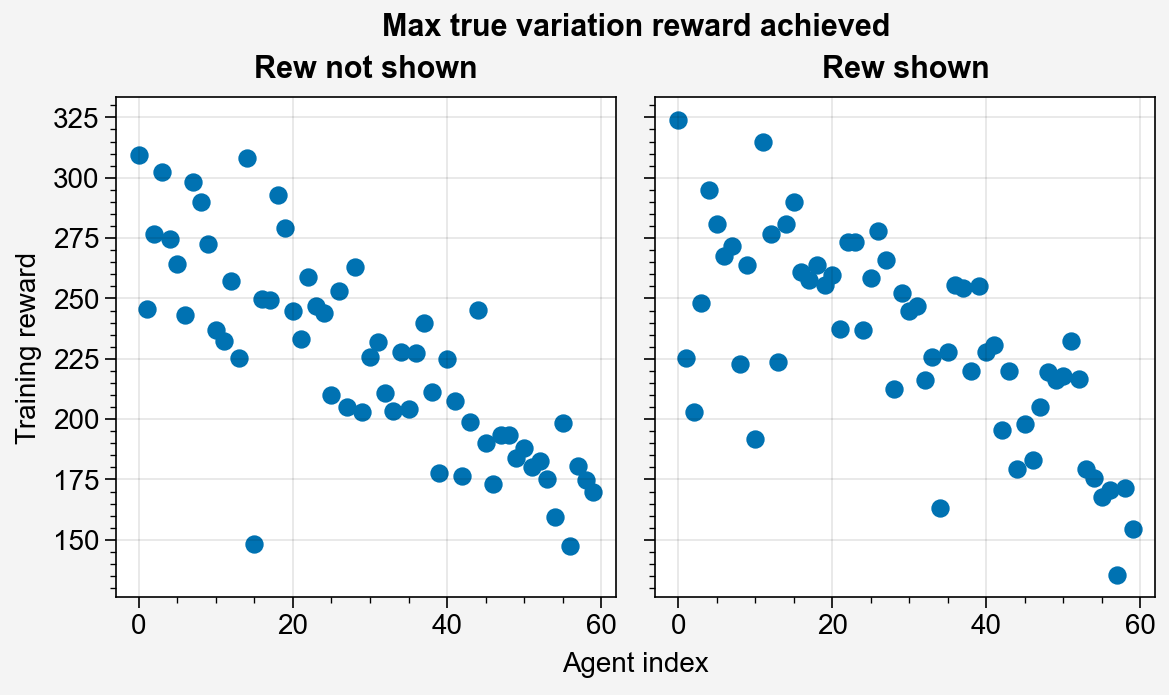

In [118]:
max_true_r = [[], []]
for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        pun = pop_vals[i]
        p = models[j]
        for h in range(2):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.sum(axis=-1)
            max_true_r[h].append(true_r.max(axis=1))
            
max_true_r = [np.concatenate(r) for r in max_true_r]
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    ax[h].scatter(max_true_r[h])

ax.format(xlabel='Agent index', toplabels=give_labels, ylabel='Training reward',
          suptitle='Max true variation reward achieved')

In [46]:
rewsum = all_rew.sum(axis=(5, 6))
bestrew = rewsum.max(axis=-1).flatten()
print((bestrew > 275).sum() / len(bestrew))

0.9


# Behavior classifications

We could think of a couple ways to classify the specific behavior of the agent
- reward seeking: how large are agents willing to push balloons
- fixed vs. adaptable: if the agent pops a similar number of balloons across a range of sizes, it is adaptable to the balloon faced
- exploration strategy: whether the agent pushes balloons early on to "test" balloons, or gradually ramps up

## Visualizing agents

In [2]:
res = pickle.load(open('data/meta_representation_results', 'rb'))
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))
mus = np.arange(0.2, 1.01, 0.05)

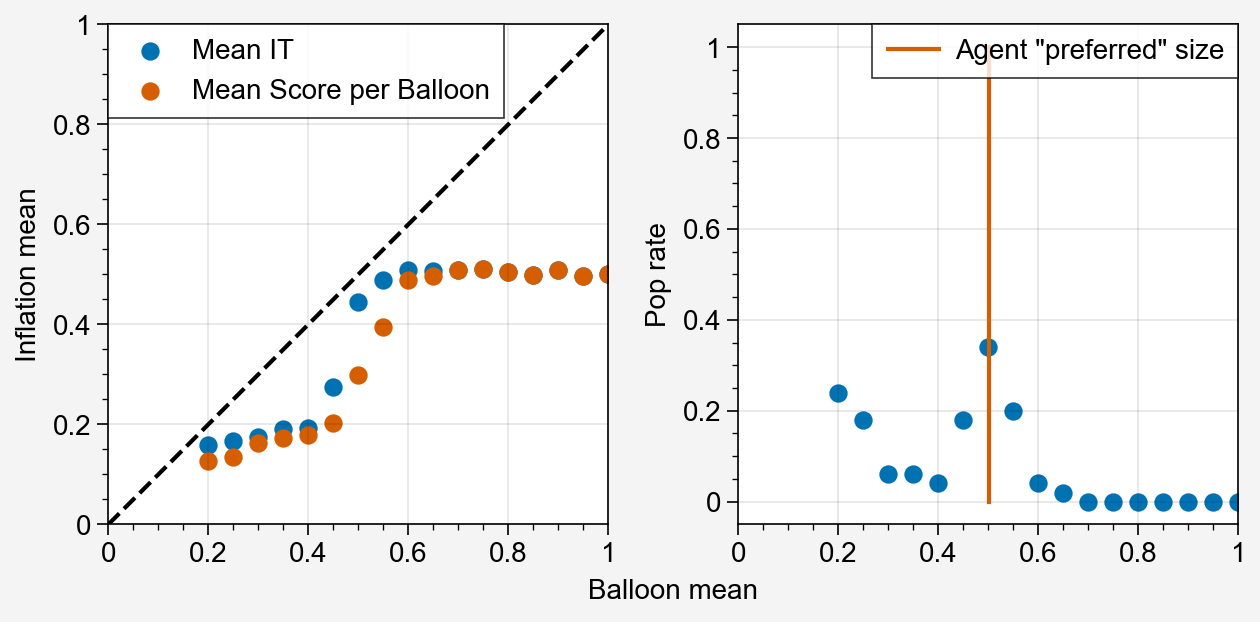

In [37]:
idxs = select_chks_by_dimension(h=0)
idx = idxs[23]
its = res['unpopped_sizes'][idx].mean(axis=1)
m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
banked = res['last_sizes'][idx].mean(axis=1)
p = res['pop_rate'][idx]

test_mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots(ncols=2, sharey=False)
ax[0].scatter(test_mus, its, label='Mean IT')
ax[0].scatter(test_mus, banked, label='Mean Score per Balloon')
ax[0].plot([0, 1], [0, 1], '--k')
# print(classify_metabart_behavior(p, m))
# print(np.sum(its*(1-p))*100)
ax[0].legend(loc='ul', ncols=1)
ax[0].format(xlabel='Balloon mean', ylabel='Inflation mean',  xlim=[0, 1], ylim=[0, 1])


ax[1].scatter(test_mus, p)
ax[1].plot([m, m], [0, 1.0], label='Agent "preferred" size')
ax[1].format(xlabel='Balloon mean', ylabel='Pop rate', xlim=[0, 1])
ax[1].legend(loc='ur')

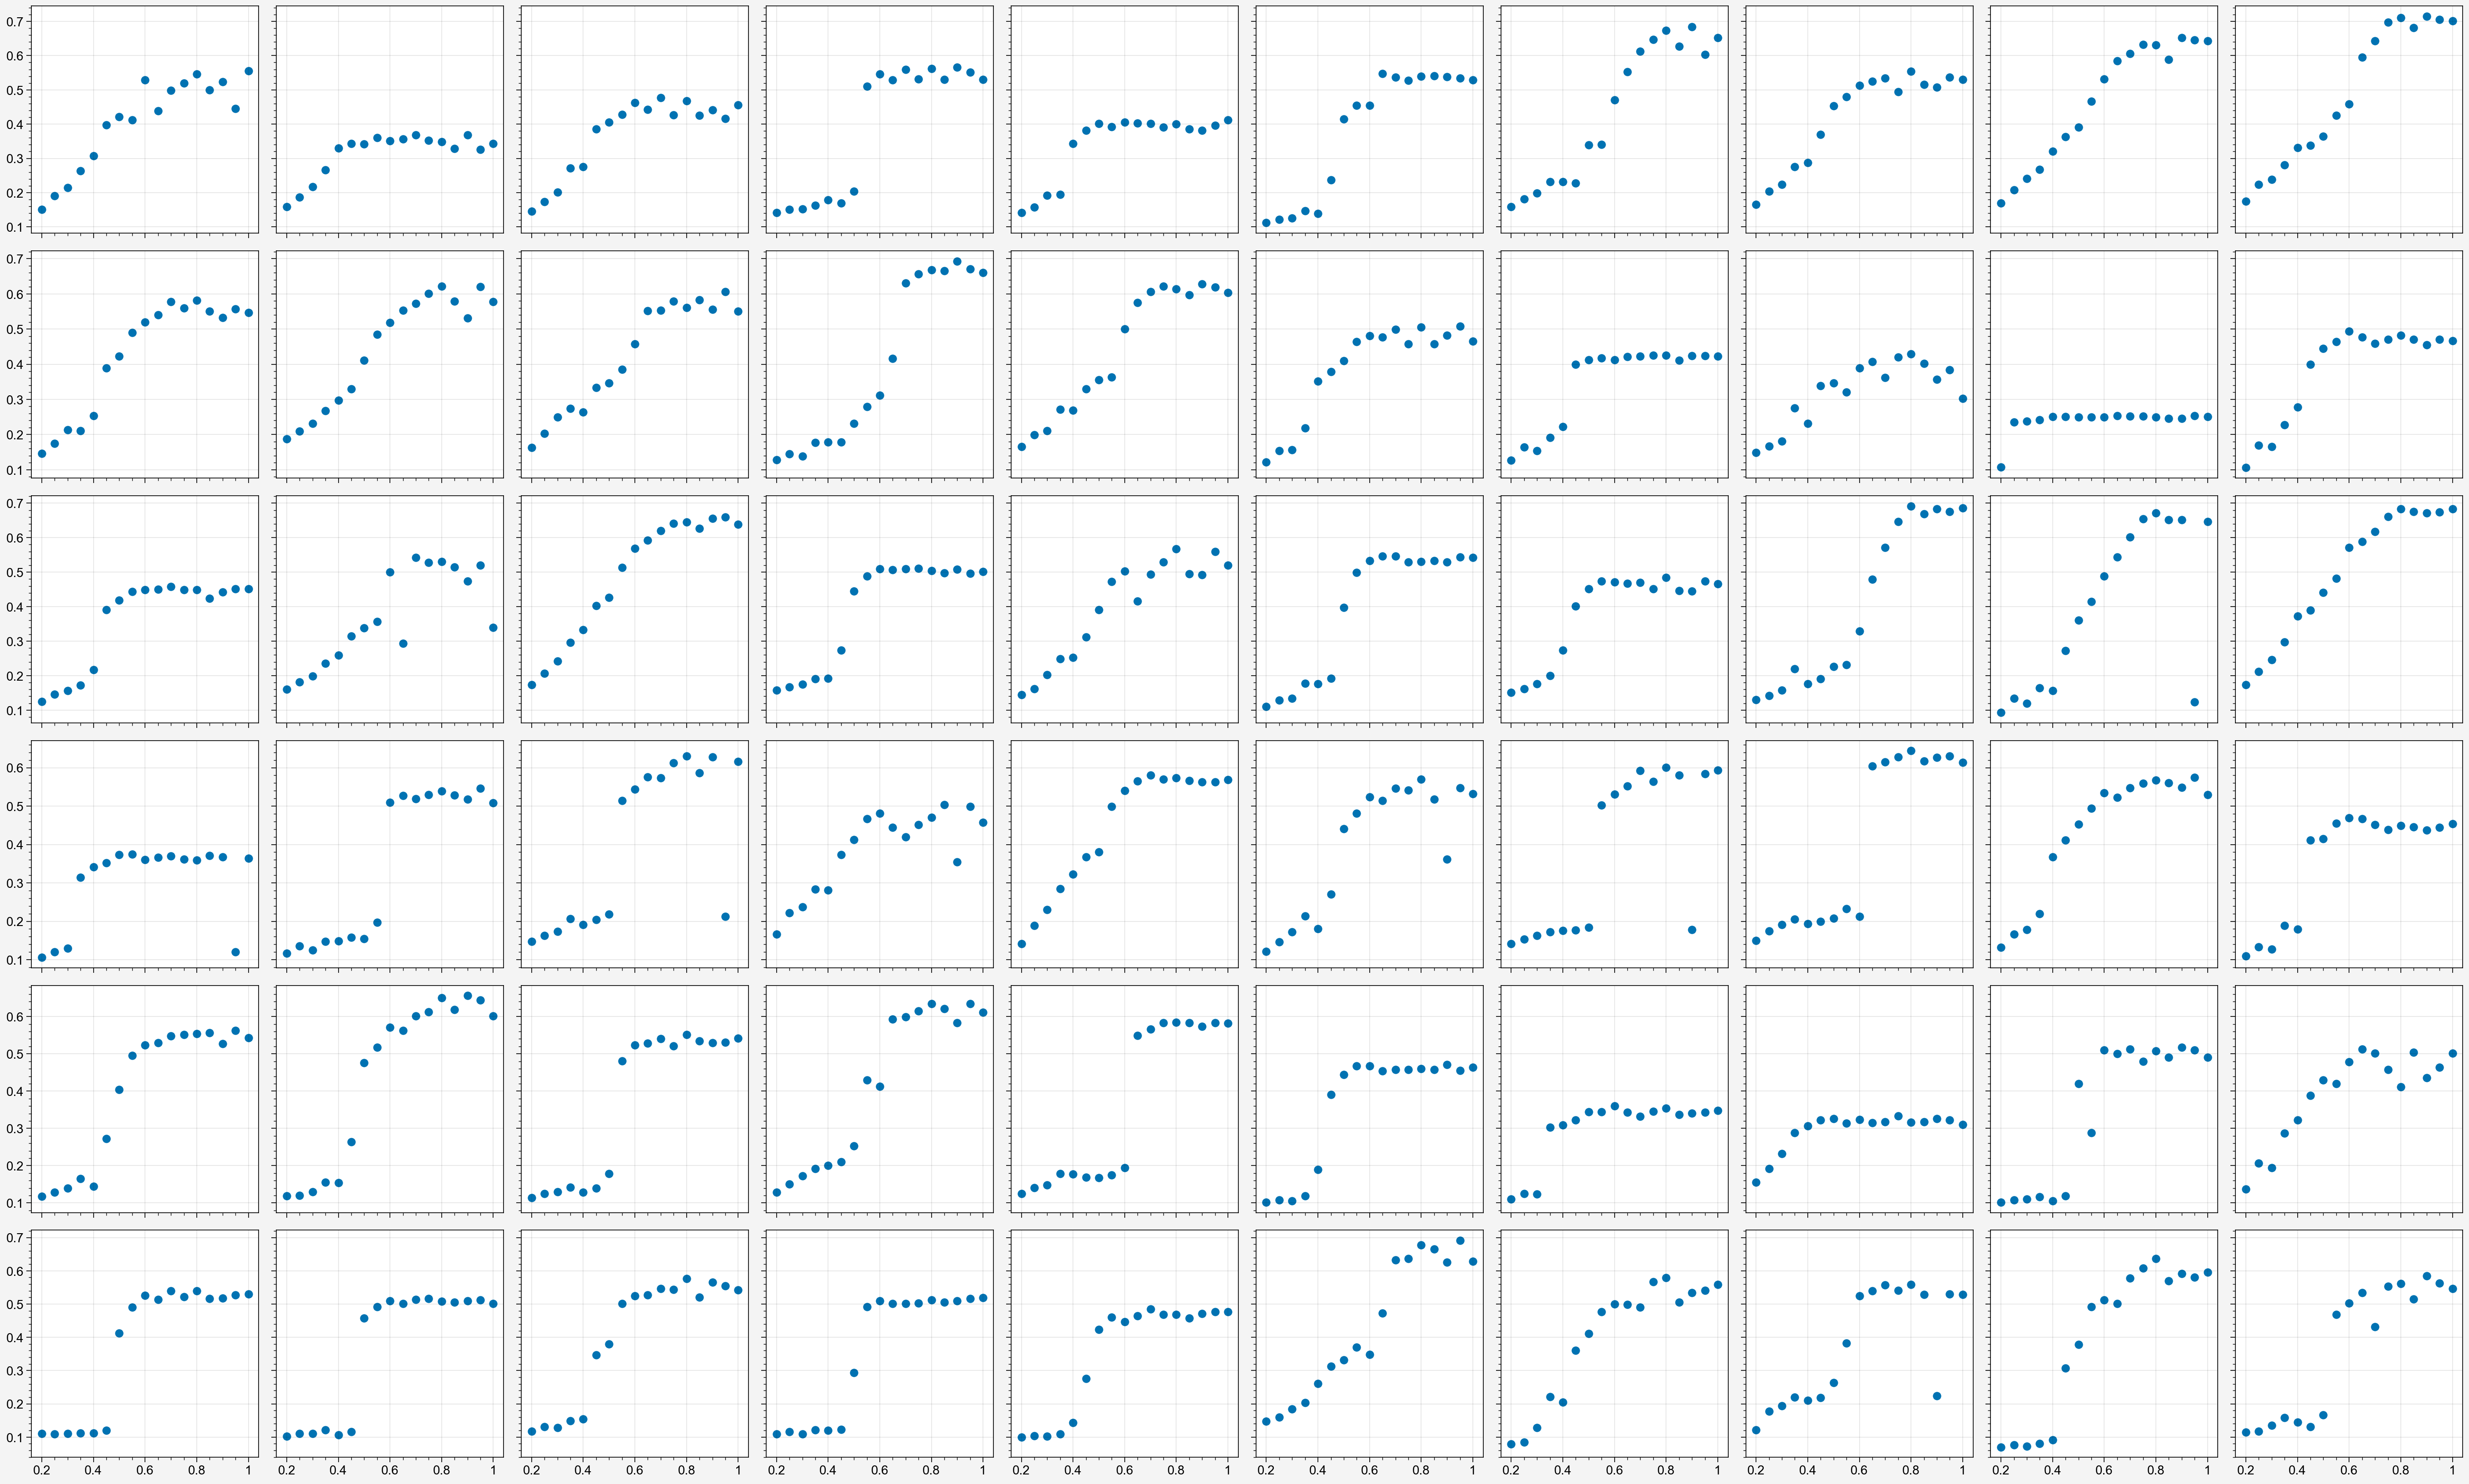

In [6]:
idxs = select_chks_by_dimension(h=0)
mus = np.arange(0.2, 1.01, 0.05)
fig, ax = pplt.subplots(nrows=6, ncols=10)
for i in range(60):
    idx = idxs[i]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    ax[i].scatter(mus, its)

## Pop shape

Agents have one of a few types of popping patterns for different balloons - constant pop rate, decreasing pop rate, and a pop rate with bump near "preferred" size

In [213]:
# look for two step local peak in pop rate
local_peak = False
for i in range(3, 13):
    p1, p2, p3, p4, p5 = p[i-2], p[i-1], p[i], p[i+1], p[i+2]
    if (p3 > 1.05 * p2) and (p3 > 1.05 * p4) and \
       (p2 > 1.05 * p1) and (p4 > 1.05 * p5):
        local_peak = True


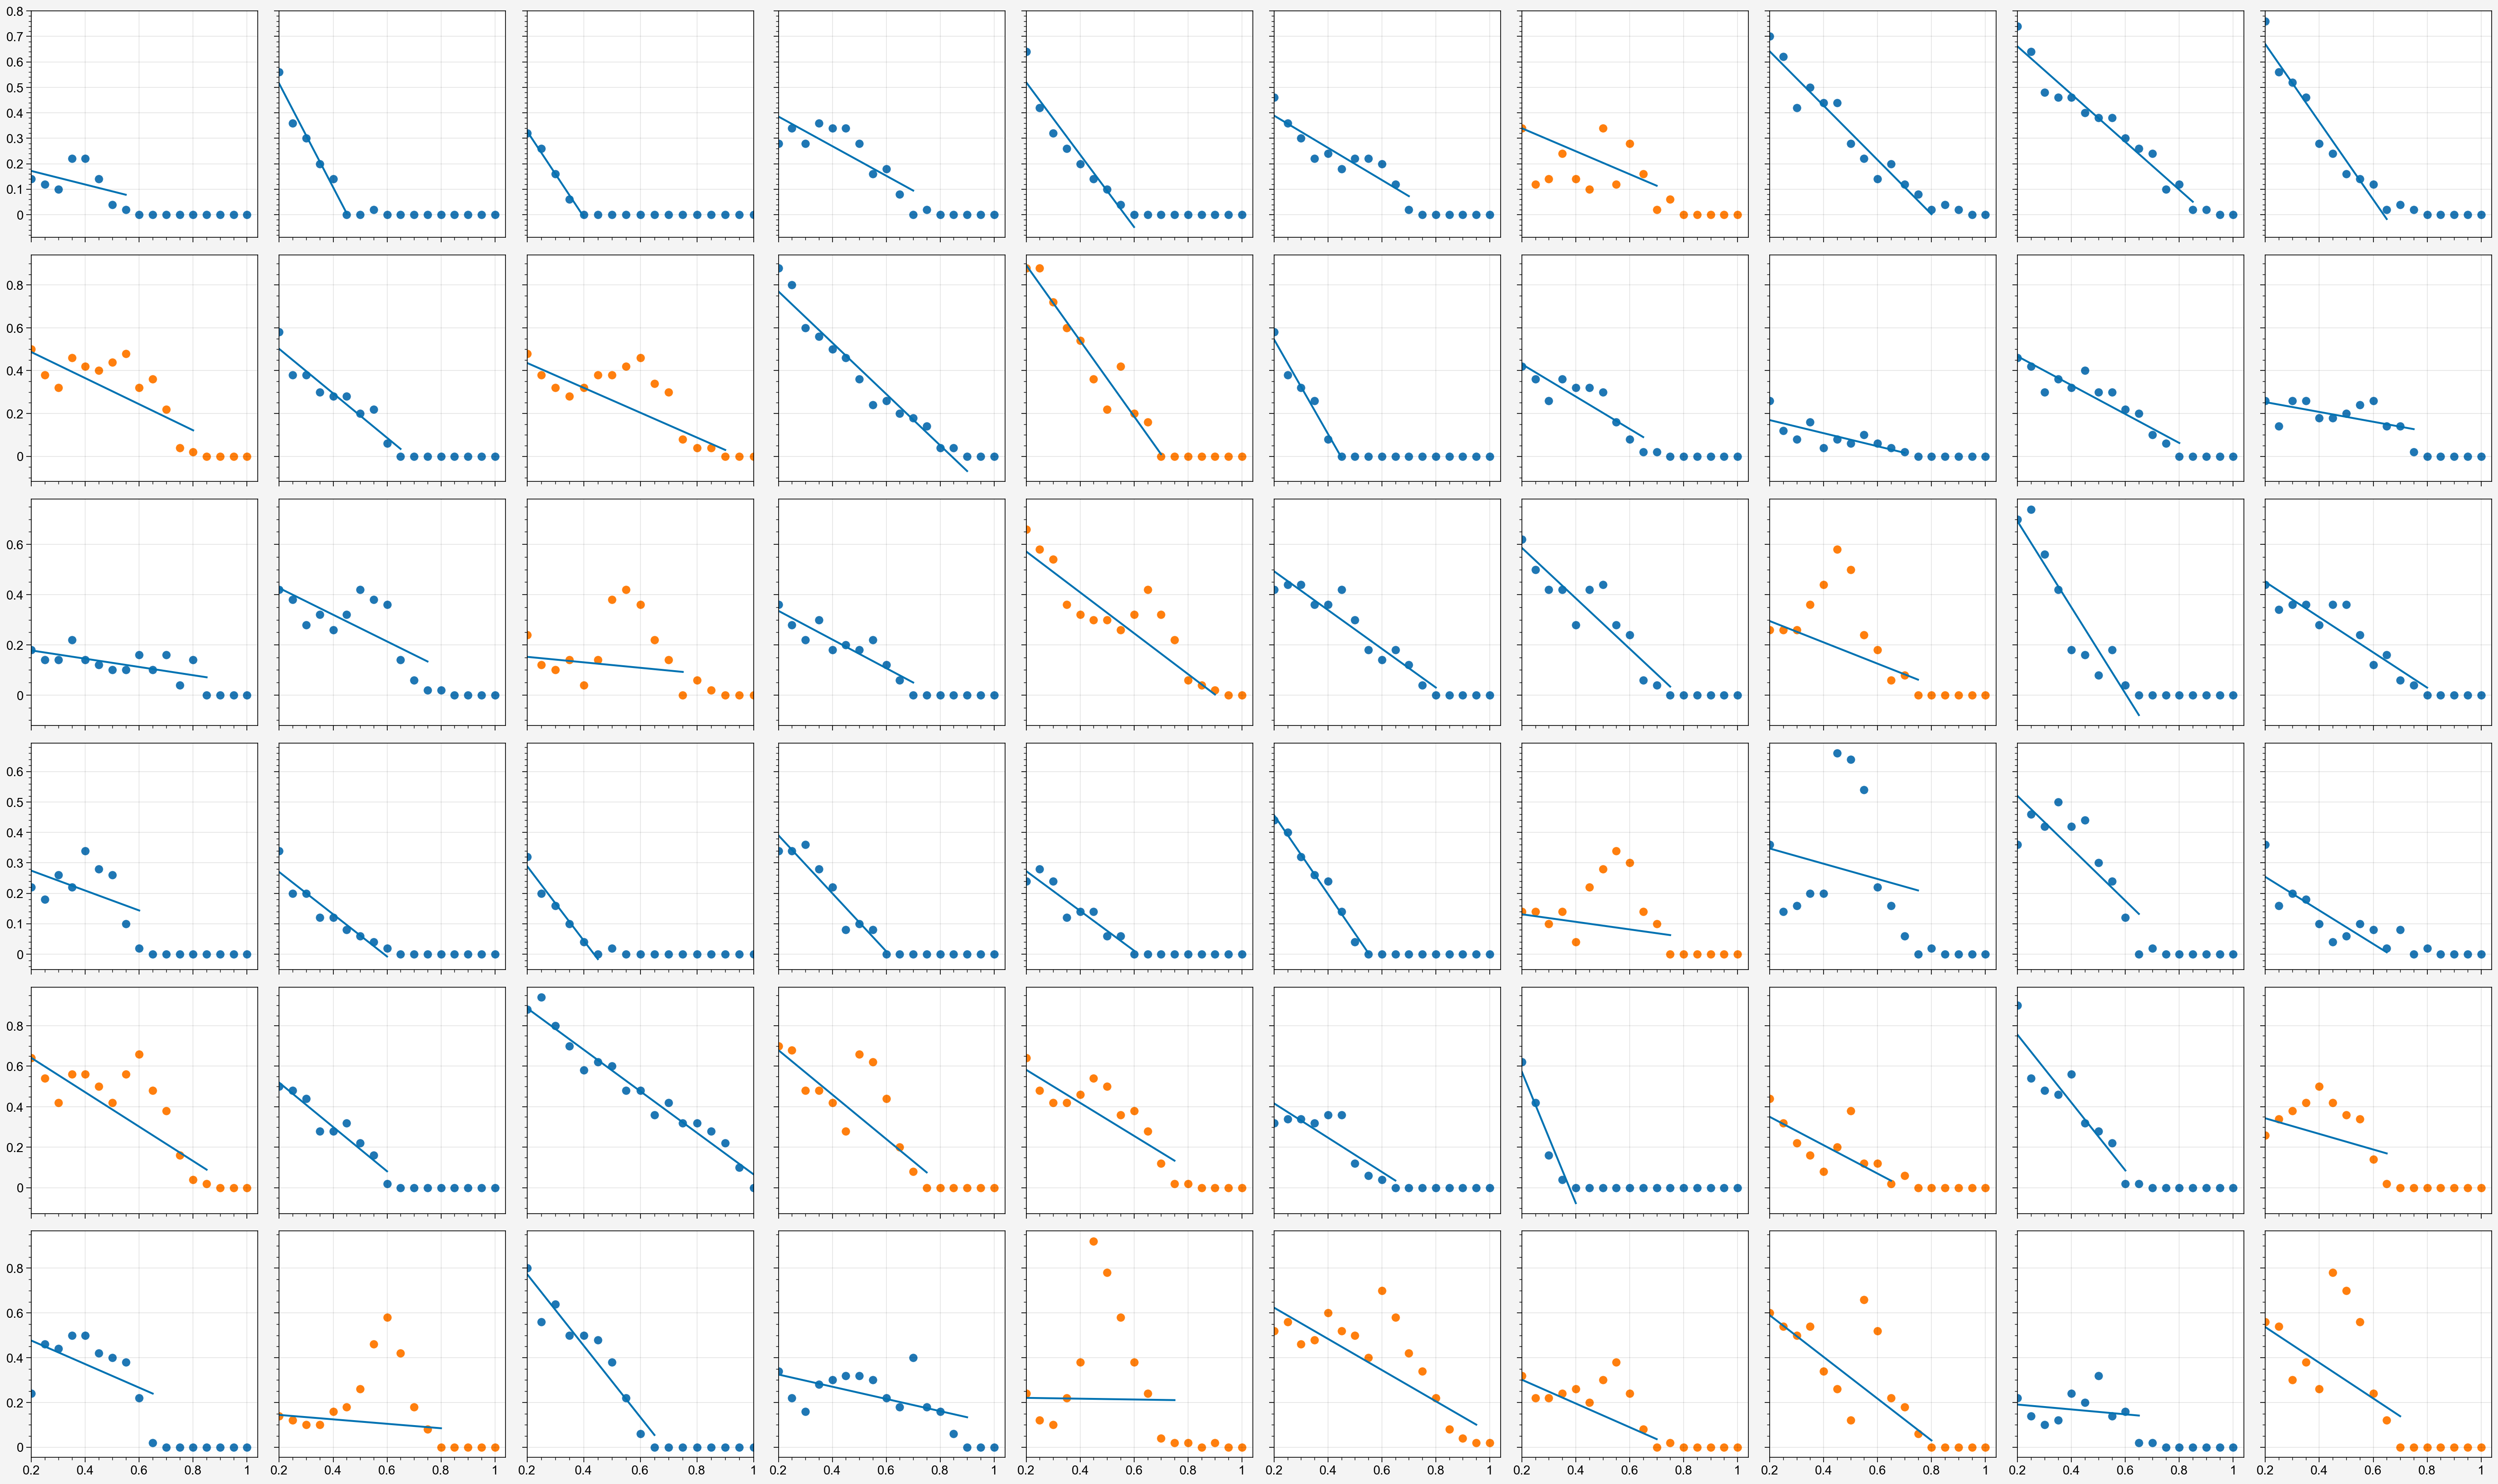

In [47]:
idxs = select_chks_by_dimension(h=1)
fig, ax = pplt.subplots(nrows=6, ncols=10)

for n in range(60):
    idx = idxs[n]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    p = res['pop_rate'][idx]
    x, y, local_peak = pop_behavior(p, ret_plot=True)
    c = rgb_colors[1] if local_peak else rgb_colors[0]
    ax[n].scatter(mus, p, c=c)
    ax[n].plot(x, y)

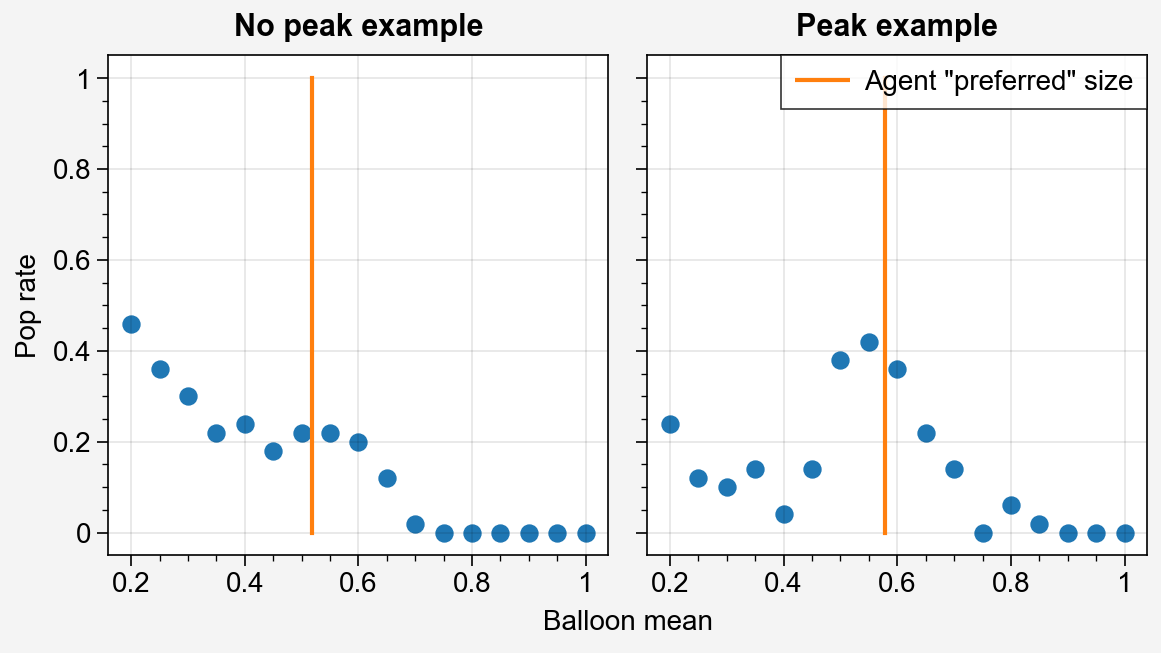

In [52]:

idxs = select_chks_by_dimension(h=1)
example_idxs = [5, 22]
fig, ax = pplt.subplots(ncols=2)

for i, idx in enumerate(example_idxs):
    idx = idxs[idx]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    p = res['pop_rate'][idx]
    m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
    x, y, local_peak = pop_behavior(p, ret_plot=True)
    # c = rgb_colors[1] if local_peak else rgb_colors[0]
    c = rgb_colors[0]
    ax[i].scatter(mus, p, c=c)
    # ax[n].plot(x, y)
    ax[i].plot([m, m], [0, 1.0], label='Agent "preferred" size', c=rgb_colors[1])

ax.format(xlabel='Balloon mean', ylabel='Pop rate', toplabels=['No peak example', 'Peak example'])
ax[1].legend(loc='ur')

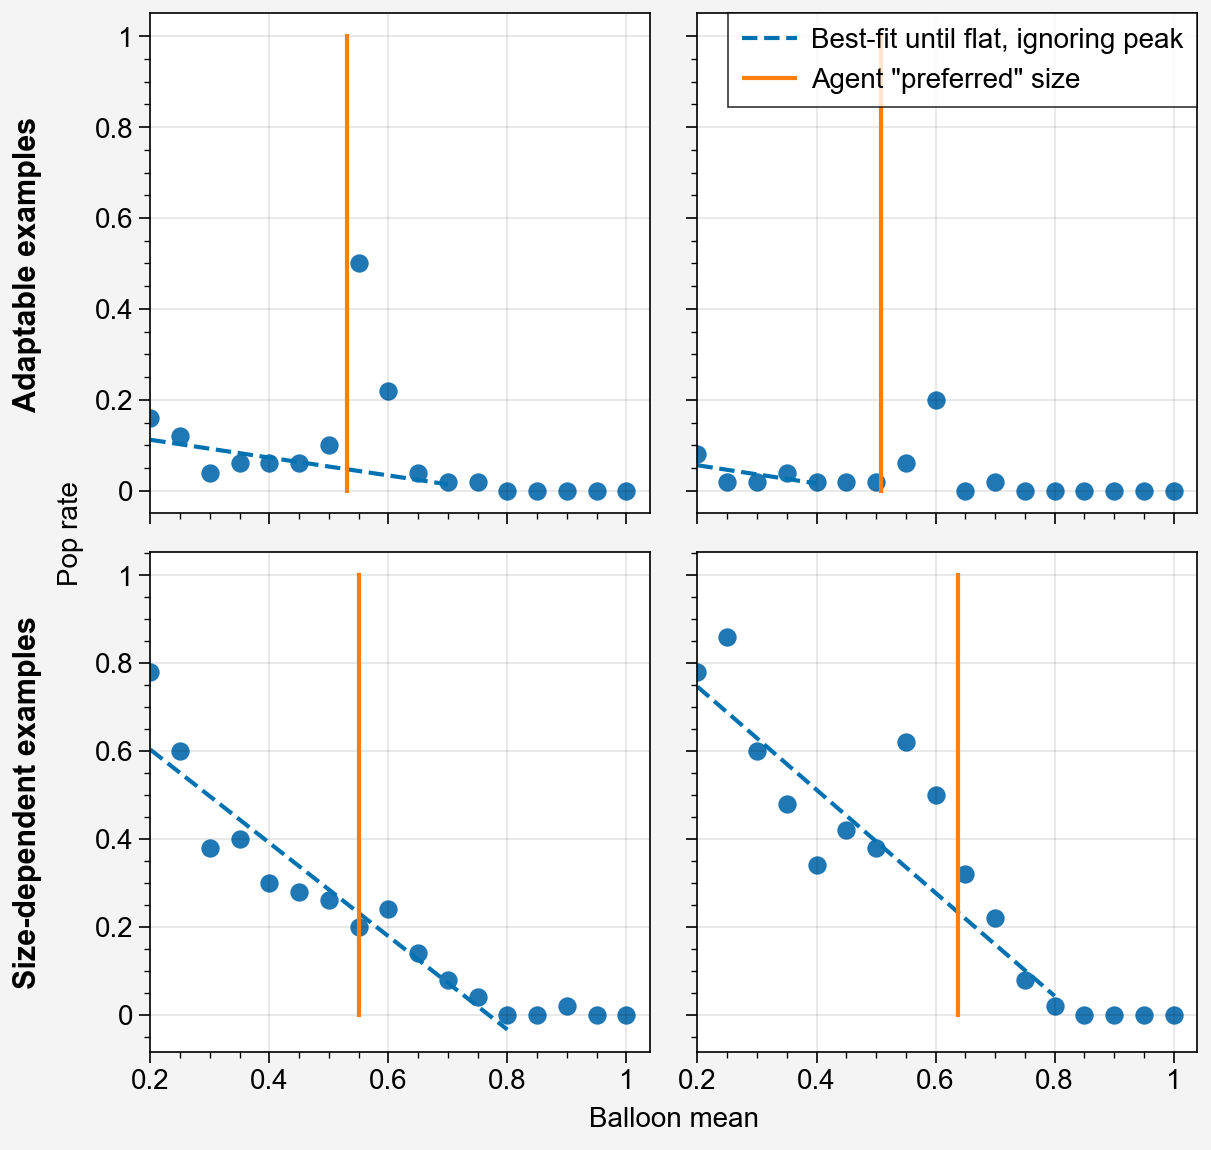

In [67]:

idxs = select_chks_by_dimension(h=0)
example_idxs = [3, 31, 12, 22]
fig, ax = pplt.subplots(nrows=2, ncols=2)

for i, idx in enumerate(example_idxs):
    idx = idxs[idx]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    p = res['pop_rate'][idx]
    m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
    x, y, local_peak = pop_behavior(p, ret_plot=True)
    # c = rgb_colors[1] if local_peak else rgb_colors[0]
    c = rgb_colors[0]
    ax[i].scatter(mus, p, c=c)
    ax[i].plot(x, y, linestyle='--', label='Best-fit until flat, ignoring peak')
    ax[i].plot([m, m], [0, 1.0], label='Agent "preferred" size', c=rgb_colors[1])

ax.format(xlabel='Balloon mean', ylabel='Pop rate', leftlabels=['Adaptable examples', 'Size-dependent examples'])
ax[1].legend(loc='ur', ncols=1)

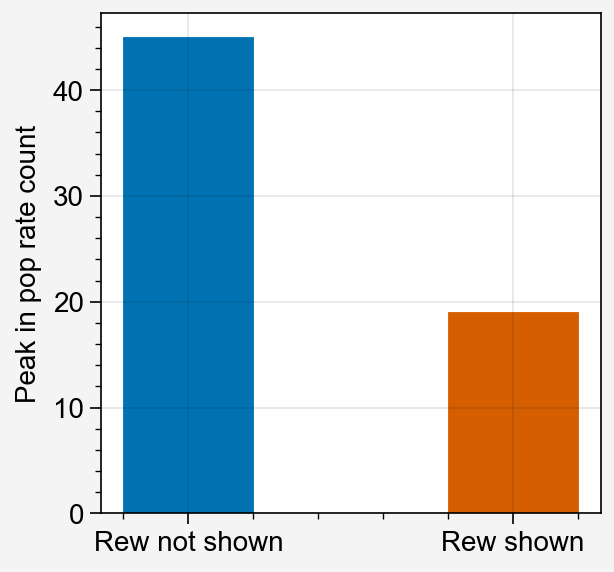

In [56]:
fig, ax = pplt.subplots()

slopes = []
for h in range(2):
    num_sloped = 0
    num_peak = 0
    idxs = select_chks_by_dimension(h=h)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        sloped = slope < -0.4
        slopes.append(slope)
        num_sloped += sloped*1
        num_peak += has_peak*1
        # num_twophase += 1*twophase

    ax.bar(h, num_peak)

ax.format(xlocator=range(2), xformatter=give_labels,
        #   toplabels=['Pop sloped behavior', 'Pop behaviors with peaks'],
          ylabel='Peak in pop rate count')

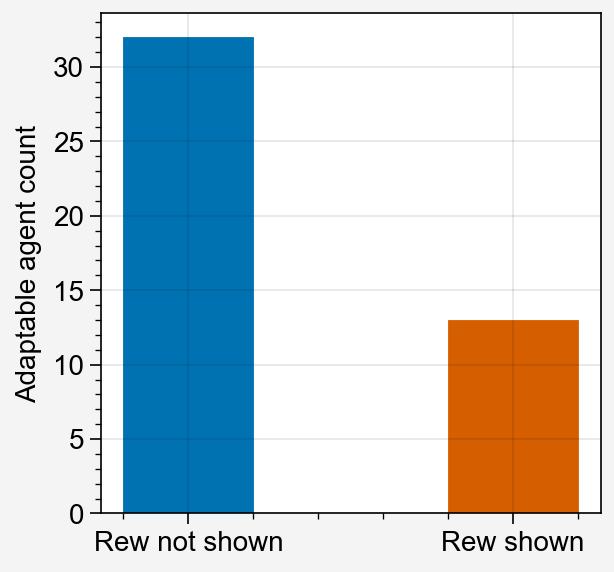

In [68]:
fig, ax = pplt.subplots()

slopes = []
for h in range(2):
    num_adaptable = 0
    idxs = select_chks_by_dimension(h=h)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        adaptable = slope > -0.4
        slopes.append(slope)
        num_adaptable += adaptable*1

    ax.bar(h, num_adaptable)

ax.format(xlocator=range(2), xformatter=give_labels,
          ylabel='Adaptable agent count')

In [16]:
%run bart_representation_analysis

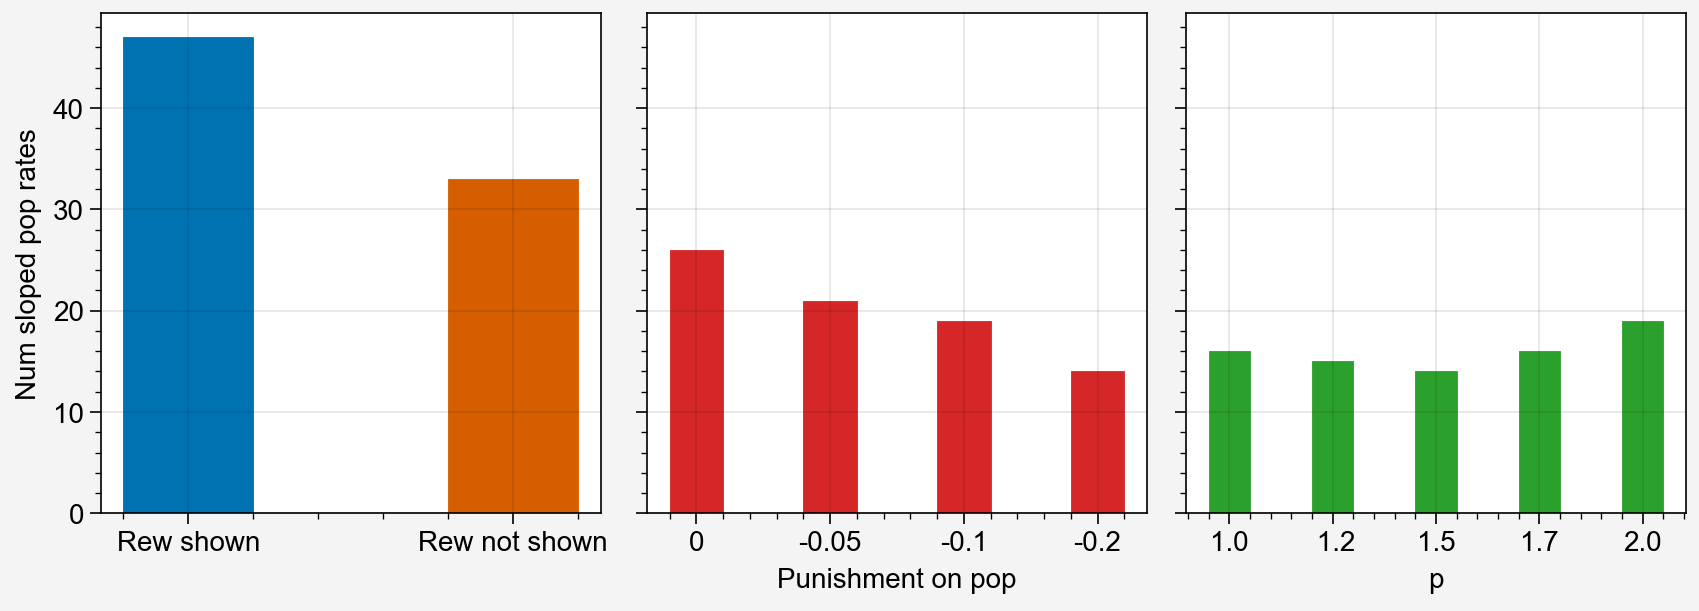

In [27]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=True)
    num_sloped = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
    ax[0].bar(h, np.mean(num_sloped))
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    num_sloped = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
    ax[1].bar(i, np.mean(num_sloped), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=True)
    num_sloped = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
    ax[2].bar(j, np.mean(num_sloped), c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Num sloped pop rates')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

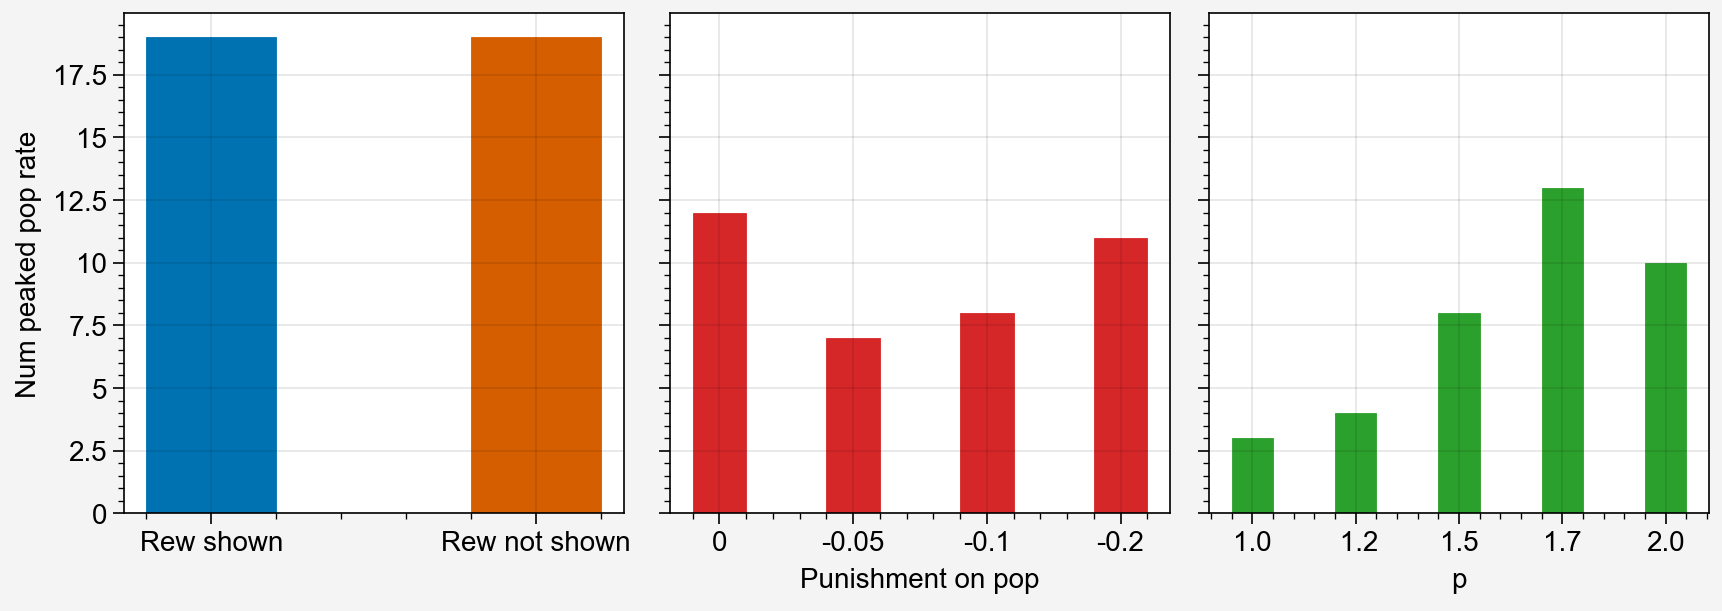

In [29]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=True)
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        num_peak += has_peak*1
    ax[0].bar(h, num_peak)
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        num_peak += has_peak*1
    ax[1].bar(i, num_peak, c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=True)
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        num_peak += has_peak*1
    ax[2].bar(j, num_peak, c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Num peaked pop rate')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

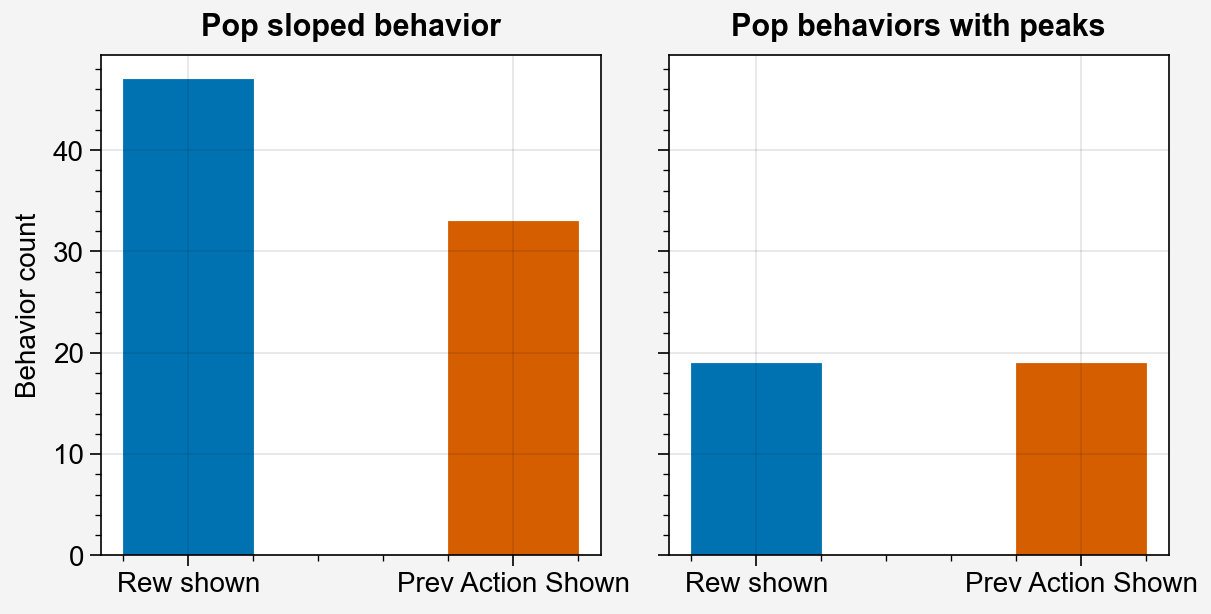

In [7]:
fig, ax = pplt.subplots(ncols=2)

slopes = []
for h in range(1, 3):
    num_sloped = 0
    num_peak = 0
    idxs = select_chks_by_dimension(h=h)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        sloped = slope < -0.4
        slopes.append(slope)
        num_sloped += sloped*1
        num_peak += has_peak*1
        # num_twophase += 1*twophase

    ax[0].bar(h, num_sloped)
    ax[1].bar(h, num_peak)

ax.format(xlocator=range(1, 3), xformatter=give_labels[1:],
          toplabels=['Pop sloped behavior', 'Pop behaviors with peaks'],
          ylabel='Behavior count')

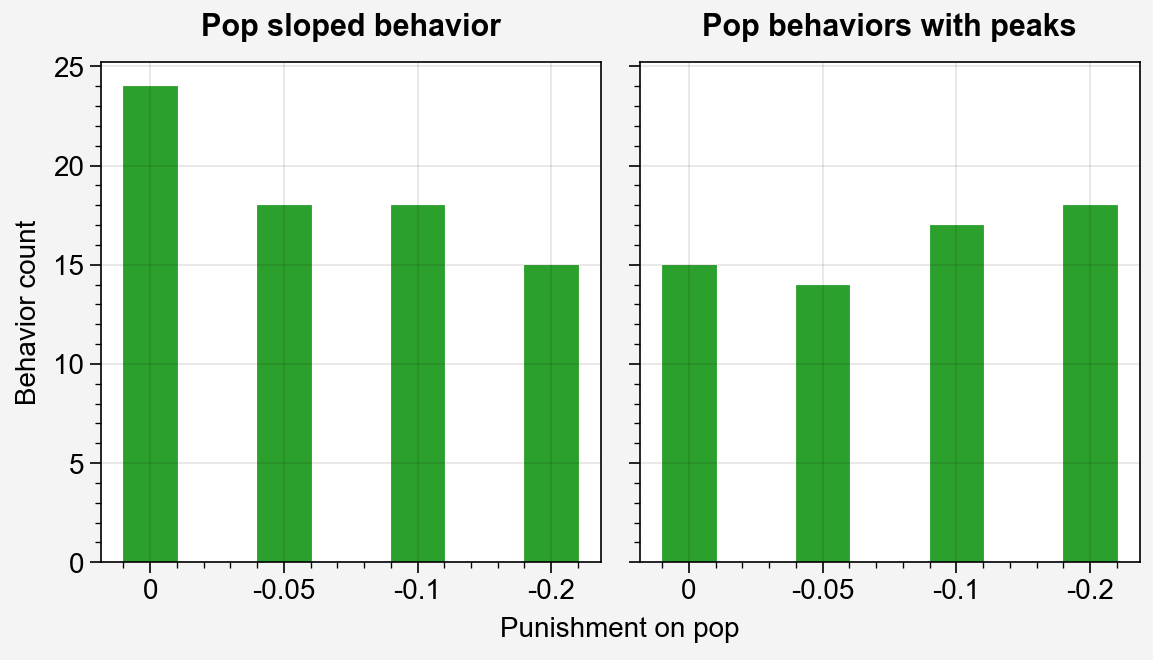

In [8]:
fig, ax = pplt.subplots(ncols=2)

slopes = []
for i in range(4):
    num_sloped = 0
    num_peak = 0
    idxs = select_chks_by_dimension(i=i)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        sloped = slope < -0.4
        slopes.append(slope)
        num_sloped += sloped*1
        num_peak += has_peak*1
        # num_twophase += 1*twophase

    ax[0].bar(i, num_sloped, c=rgb_colors[2])
    ax[1].bar(i, num_peak, c=rgb_colors[2])

ax.format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
          toplabels=['Pop sloped behavior', 'Pop behaviors with peaks'],
          ylabel='Behavior count')

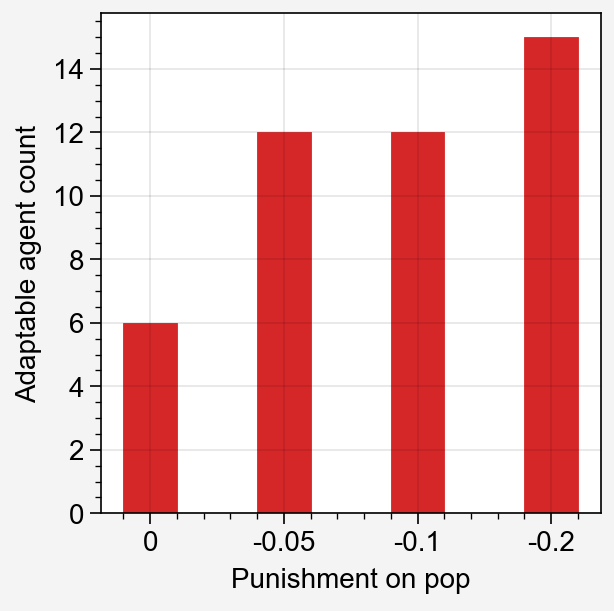

In [9]:
fig, ax = pplt.subplots()

slopes = []
for i in range(4):
    num_adaptable = 0
    idxs = select_chks_by_dimension(i=i)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        adaptable = slope > -0.4
        slopes.append(slope)
        num_adaptable += adaptable*1

    ax.bar(i, num_adaptable, c=rgb_colors[3])

ax.format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
          ylabel='Adaptable agent count')

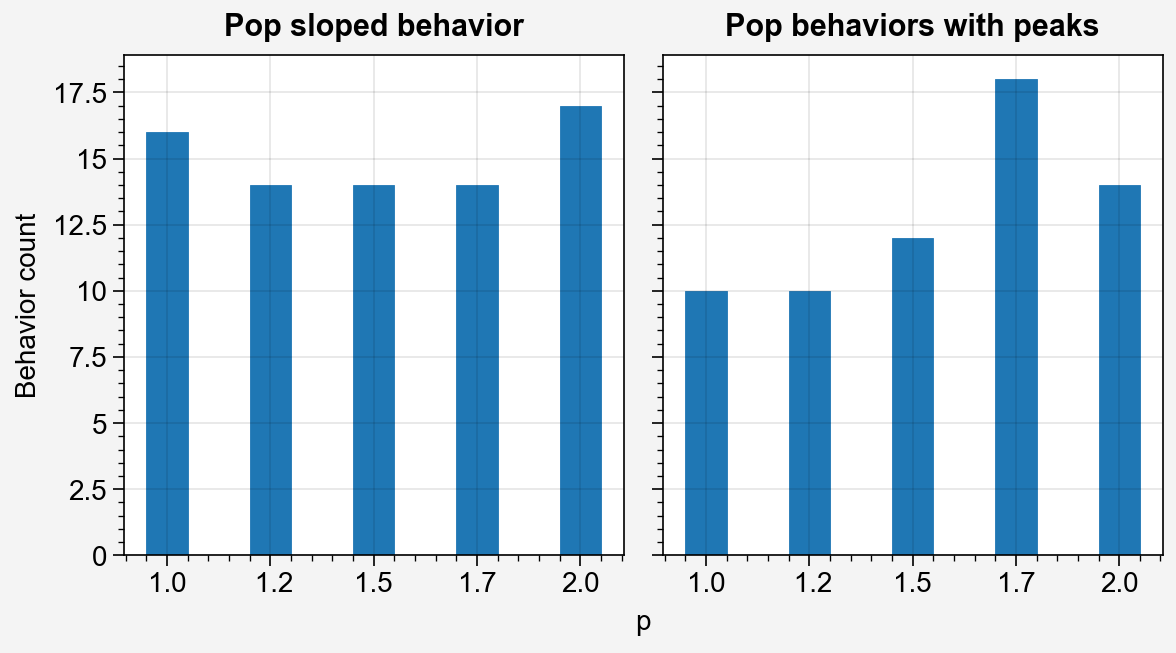

In [278]:
fig, ax = pplt.subplots(ncols=2)

slopes = []
for j in range(5):
    num_sloped = 0
    num_peak = 0
    idxs = select_chks_by_dimension(j=j)
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)

        sloped = slope < -0.4
        slopes.append(slope)
        num_sloped += sloped*1
        num_peak += has_peak*1
        # num_twophase += 1*twophase

    ax[0].bar(j, num_sloped, c=rgb_colors[0])
    ax[1].bar(j, num_peak, c=rgb_colors[0])

ax.format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
          toplabels=['Pop sloped behavior', 'Pop behaviors with peaks'],
          ylabel='Behavior count')

## Bimodal inflation behavior

Some agents exhibit a much clearer two phase behavior dynamics. Simple meethod of calculating: see if there is a jump of more than 0.15 mean inflation time between 2 balloon sizes

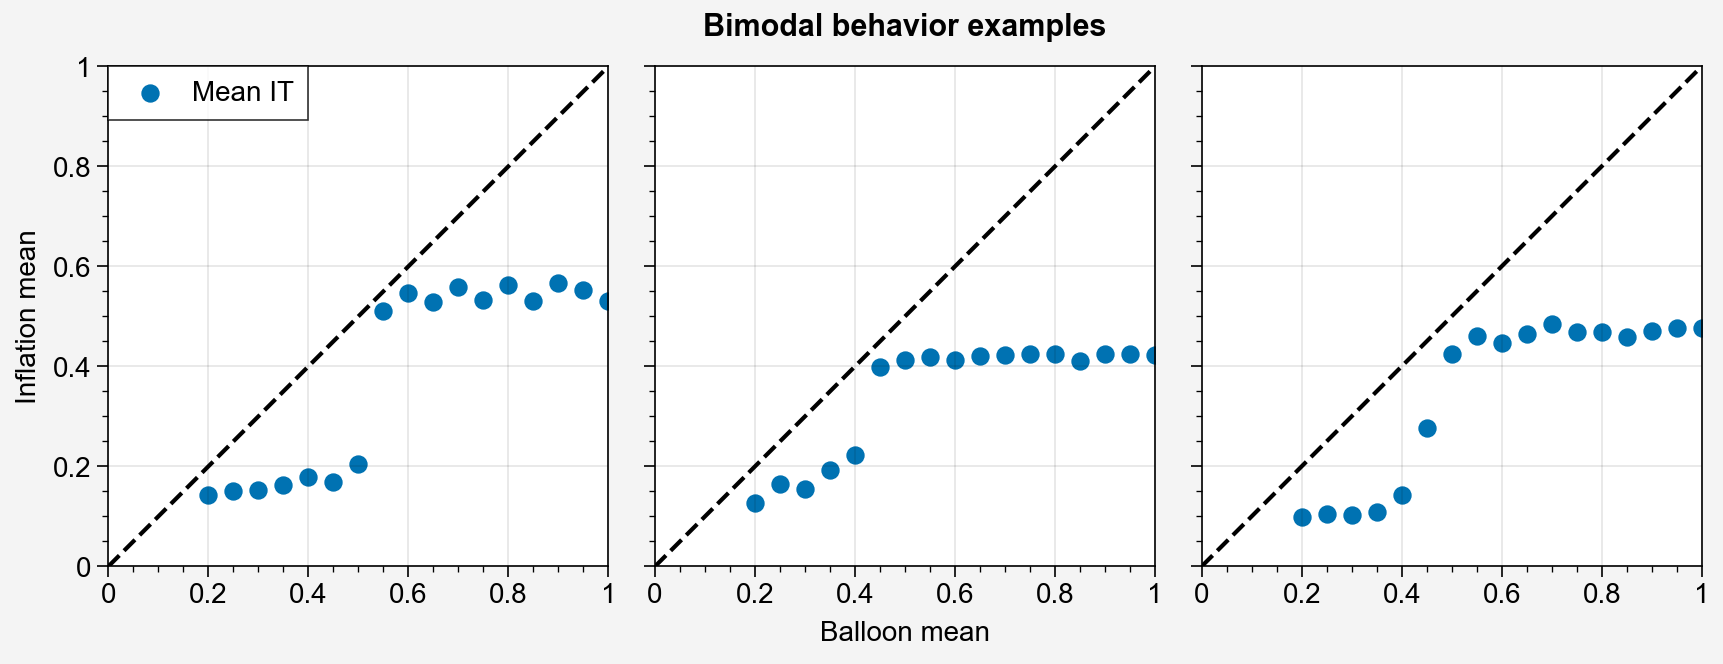

In [ ]:
idxs = select_chks_by_dimension(h=0)
two_phase_idxs = [3, 16, 54]
fig, ax = pplt.subplots(ncols=3)
for i, idx in enumerate(two_phase_idxs):
    idx = idxs[idx]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
    p = res['pop_rate'][idx]

    ax[i].scatter(mus, its, label='Mean IT')
    # ax[i].scatter(mus, its*(1-p), label='Mean IT w/pops')
    ax[i].plot([0, 1], [0, 1], '--k')
ax[0].legend(loc='ul', ncols=1)
ax.format(xlabel='Balloon mean', ylabel='Inflation mean',  xlim=[0, 1], ylim=[0, 1],
          suptitle='Bimodal behavior examples')

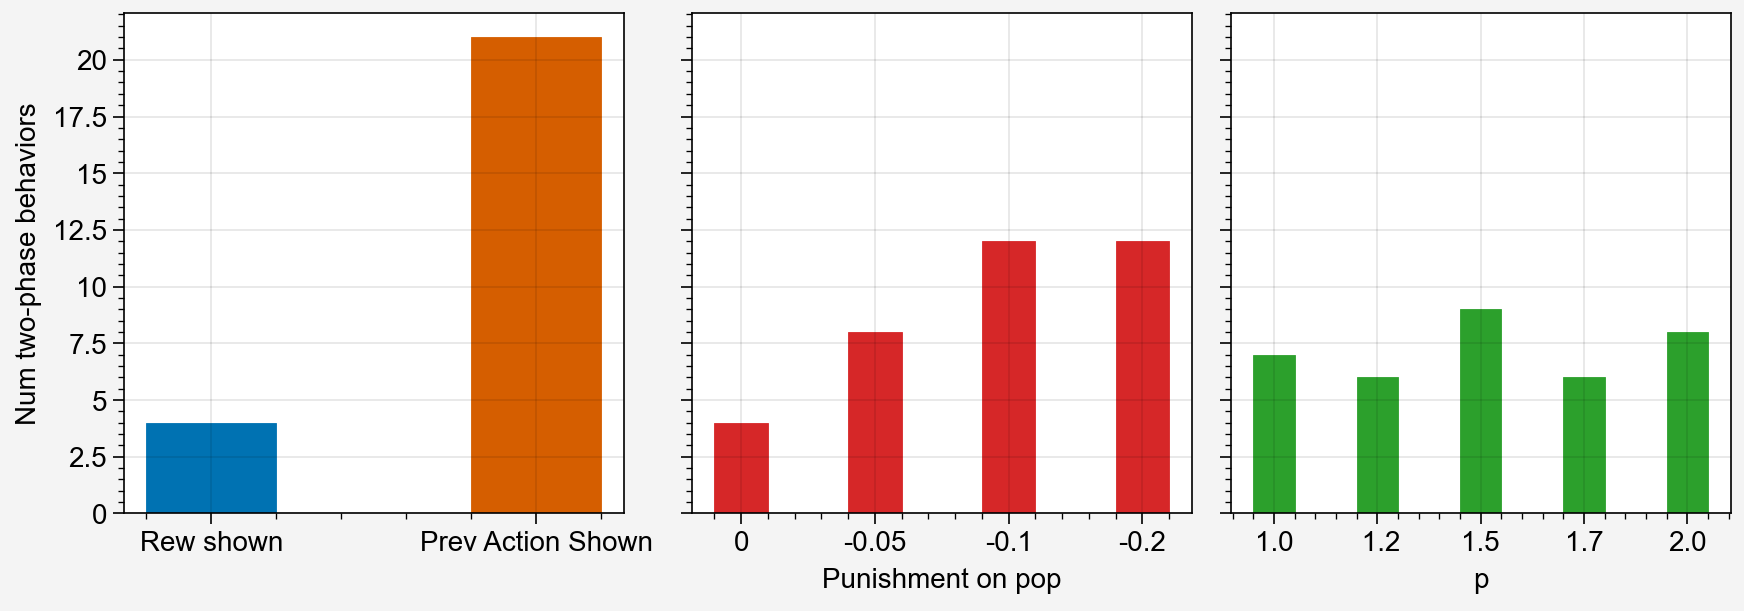

In [19]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(1, 3):
    idxs = select_chks_by_dimension(h=h)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[0].bar(h, num_twophase)
for i in range(4):
    idxs = select_chks_by_dimension(i=i)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[1].bar(i, num_twophase, c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[2].bar(j, num_twophase, c=rgb_colors[2])

ax[0].format(xlocator=range(1, 3), xformatter=give_labels[1:], ylabel='Num two-phase behaviors')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

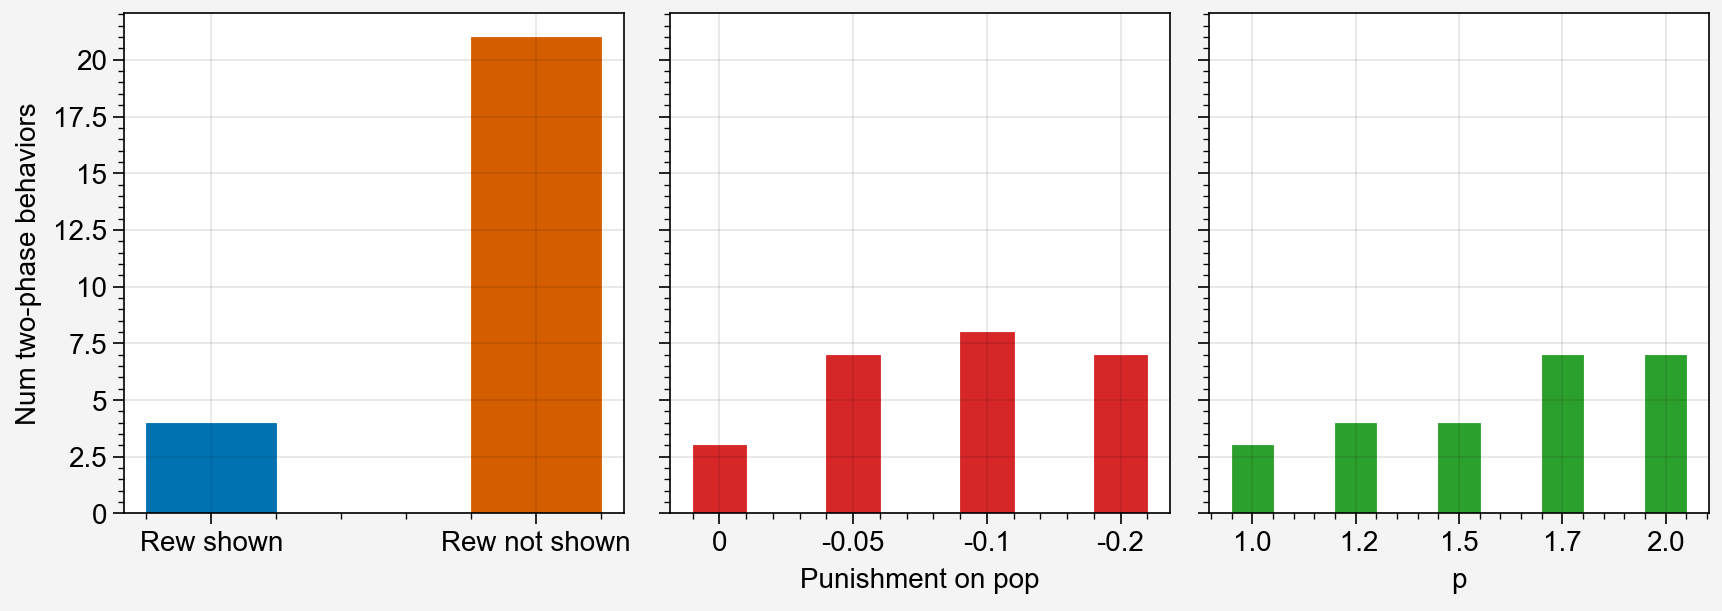

In [30]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[0].bar(h, num_twophase)
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[1].bar(i, num_twophase, c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[2].bar(j, num_twophase, c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Num two-phase behaviors')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

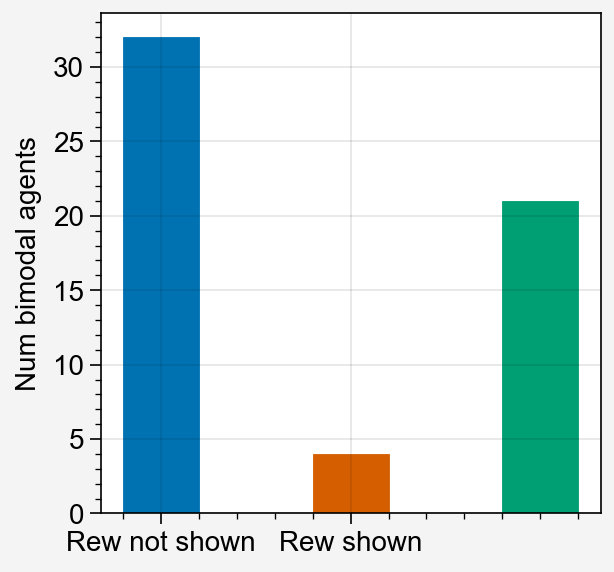

In [14]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

for h in range(3):
    num_twophase = 0
    idxs = select_chks_by_dimension(h=h)
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]

        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase

    ax.bar(h, num_twophase)
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Num bimodal agents')

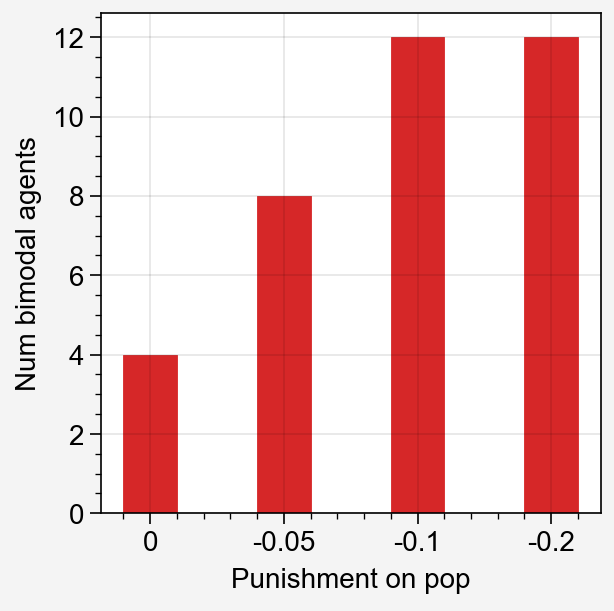

In [18]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

for i in range(4):
    num_twophase = 0
    idxs = select_chks_by_dimension(i=i)
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]

        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase

    ax.bar(i, num_twophase, c=rgb_colors[3])
ax.format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
          ylabel='Num bimodal agents')



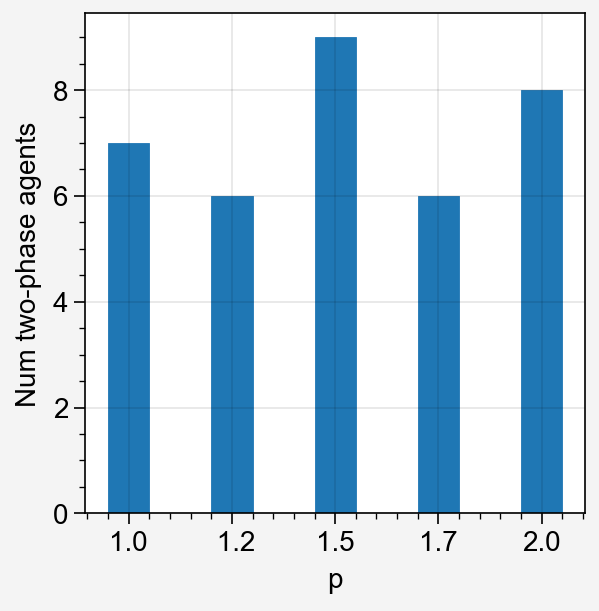

In [182]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

for j in range(5):
    num_twophase = 0
    idxs = select_chks_by_dimension(j=j)
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]

        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase

    ax.bar(j, num_twophase, c=rgb_colors[0])
ax.format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
          ylabel='Num two-phase agents')



## Reward seeking

Very simple measure of largest balloons agents attempt to get regardless of pop size

In [ ]:
idxs = select_chks_by_dimension(h=1)
example_idxs = [2, 55]
fig, ax = pplt.subplots(ncols=2)
for i, idx in enumerate(example_idxs):
    idx = idxs[idx]
    its = res['unpopped_sizes'][idx].mean(axis=1)
    p = res['pop_rate'][idx]

    m = np.argmax(its)
    
    ax[i].scatter(mus, its, label='Mean IT')
    ax[i].scatter(mus[m], its[m], c=rgb_colors[3], label='Largest Mean IT', s=50)

    # ax[i].scatter(mus, its*(1-p), label='Mean IT w/pops')
    ax[i].plot([0, 1], [0, 1], '--k')
ax[0].legend(loc='ul', ncols=1)
ax.format(xlabel='Balloon mean', ylabel='Inflation mean',  xlim=[0, 1], ylim=[0, 1],
          suptitle='Largest IT examples (ignoring pops)')

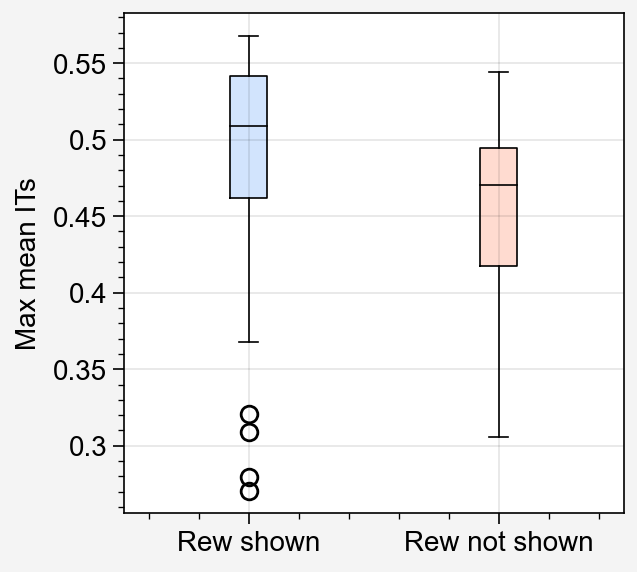

In [43]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

all_seek = []
for h in range(2):
    max_its = []
    idxs = select_chks_by_dimension(h=h, i=range(4))
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        max_its.append(its.max())

    all_seek.append(max_its)
    ax.boxplot(h, max_its, cycle=rgb_colors[h])
    # ax.bar(h, max_its)
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Max mean ITs')

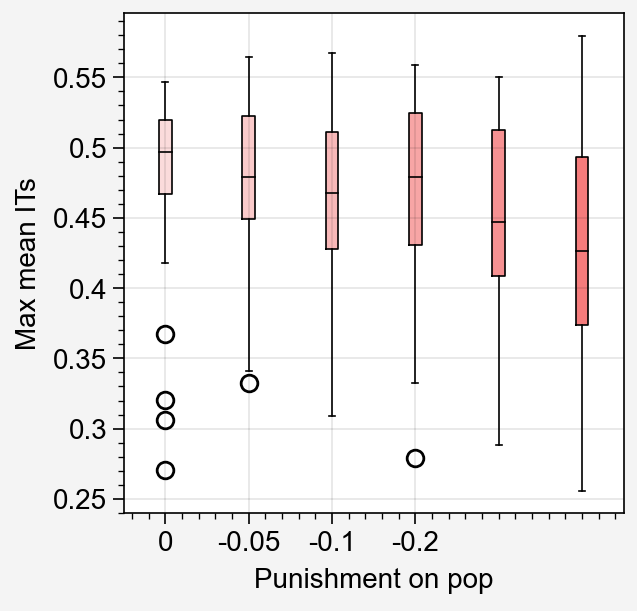

In [ ]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

for i in range(6):
    max_its = []
    idxs = select_chks_by_dimension(i=i)
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        max_its.append(its.max())

    ax.boxplot(i, max_its, cycle=rgb_colors[3])
ax.format(xlocator=range(6), xformatter=pop_labels, xlabel=pop_axis,
          ylabel='Max mean ITs')

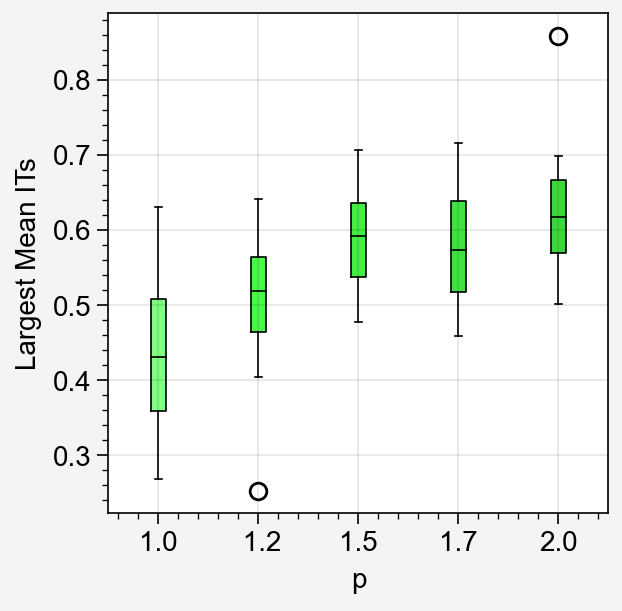

In [43]:
mus = np.arange(0.2, 1.01, 0.05)

fig, ax = pplt.subplots()

for j in range(5):
    max_its = []
    idxs = select_chks_by_dimension(j=j)
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        max_its.append(its.max())

    ax.boxplot(j, max_its, cycle=rgb_colors[2])
ax.format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
          ylabel='Largest Mean ITs')

## Exploration strategy

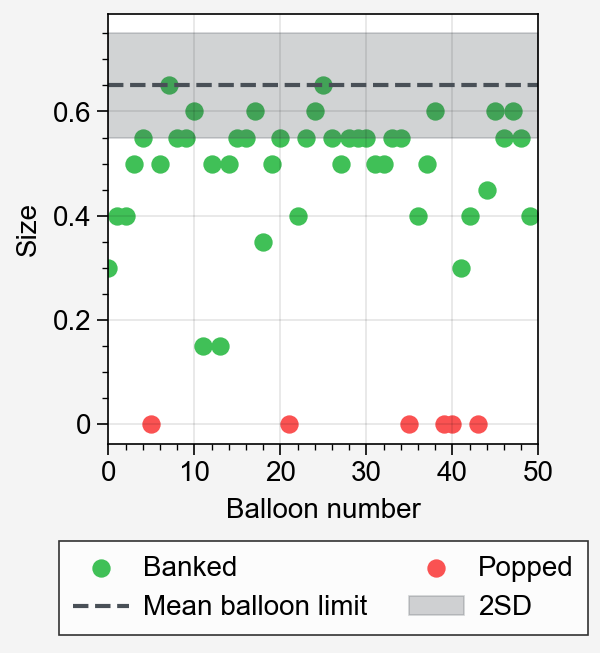

In [418]:
fig, ax = pplt.subplots(figwidth=3)
idx = idxs[5]

ep = 9
x = np.arange(50)
it = res['last_sizes'][idx][ep]

lines = []
lines.append(ax.scatter(x[it != 0], it[it != 0], c='green6', label='Banked'))
lines.append(ax.scatter(x[it == 0], it[it == 0], c='red6', label='Popped'))
lines.append(ax.plot([0, 50], [mus[ep], mus[ep]], c='gray7', linestyle='--', label='Mean balloon limit'))
lines.append(ax.fill_between([0, 50], [mus[ep]-0.1, mus[ep]-0.1], [mus[ep]+0.1, mus[ep]+0.1], label='2SD',
                c='gray7', alpha=0.25))
ax.format(xlabel='Balloon number', ylabel='Size')
ax.legend(lines, loc='b', ncols=2)

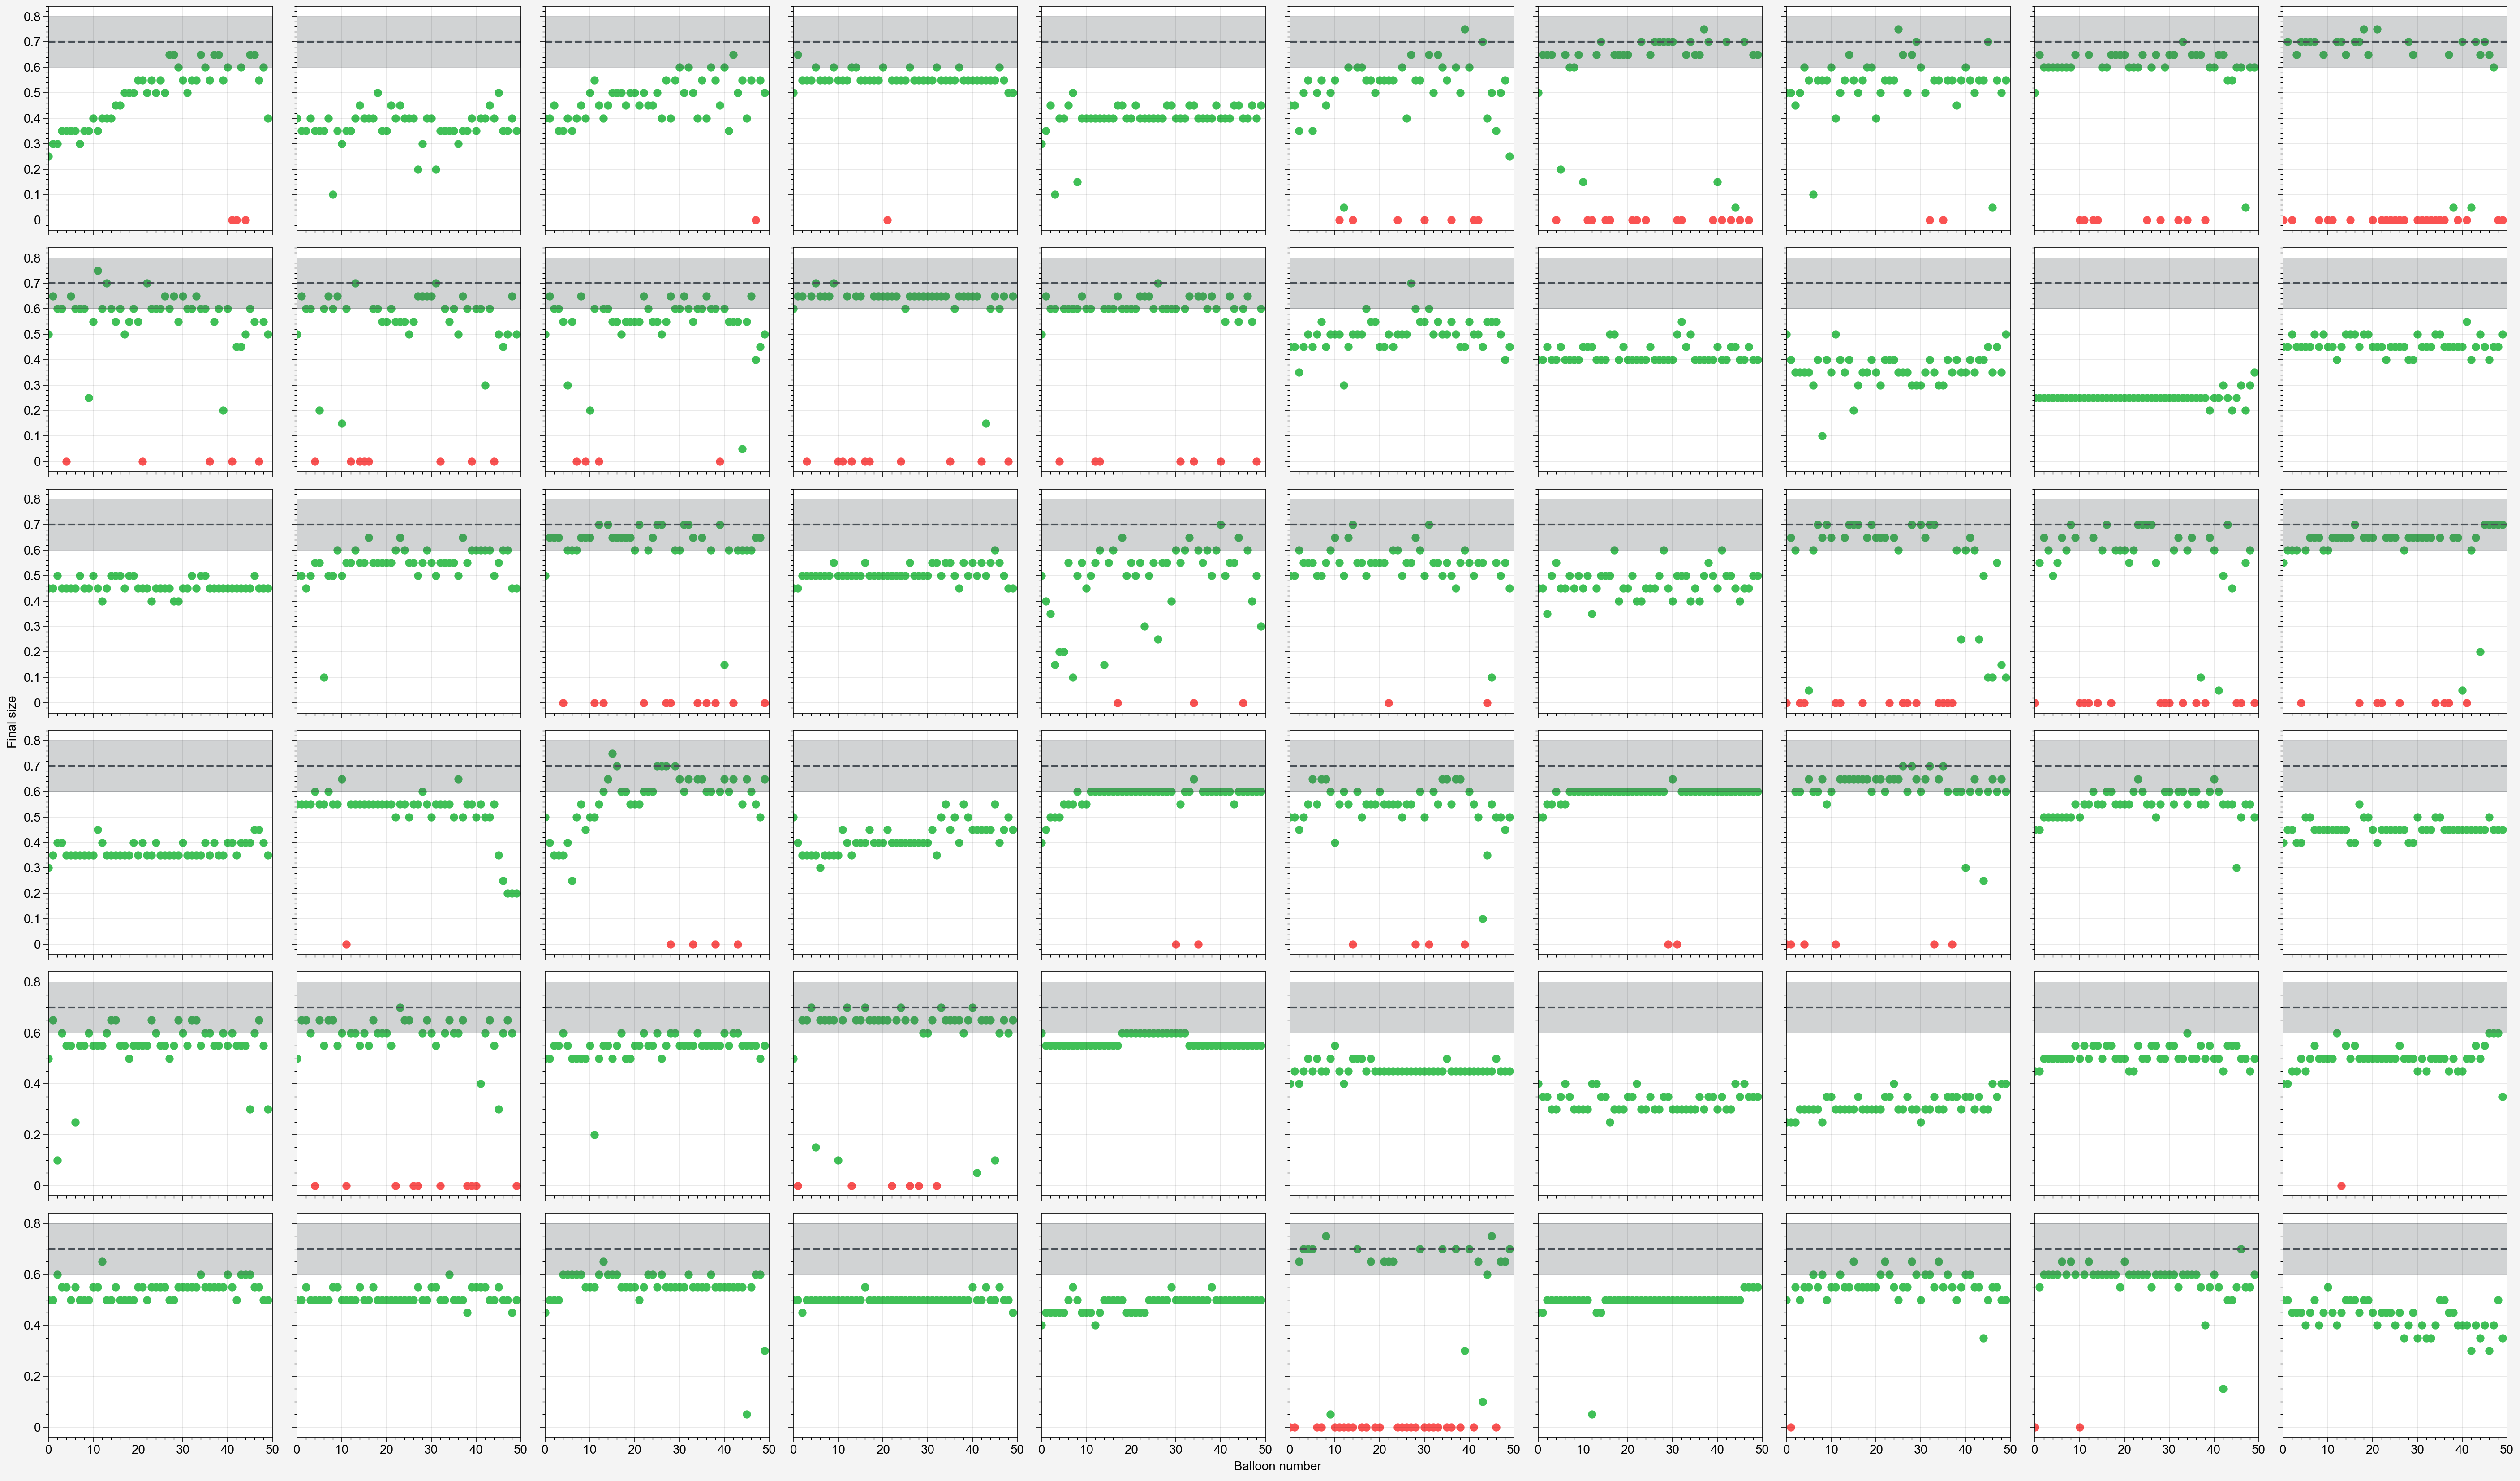

In [85]:
mus = np.arange(0.2, 1.01, 0.05)
fig, ax = pplt.subplots(nrows=6, ncols=10)
ep = 10
idxs = select_chks_by_dimension(h=0)
for i in range(60):
    idx = idxs[i]
    x = np.arange(50)
    it = res['last_sizes'][idx][ep]

    lines = []
    lines.append(ax[i].scatter(x[it != 0], it[it != 0], c='green6', label='Banked'))
    lines.append(ax[i].scatter(x[it == 0], it[it == 0], c='red6', label='Popped'))
    lines.append(ax[i].plot([0, 50], [mus[ep], mus[ep]], c='gray7', linestyle='--', label='Mean balloon limit'))
    lines.append(ax[i].fill_between([0, 50], [mus[ep]-0.1, mus[ep]-0.1], [mus[ep]+0.1, mus[ep]+0.1], label='2SD',
                    c='gray7', alpha=0.25))

ax.format(xlabel='Balloon number', ylabel='Final size')

### Early exploration

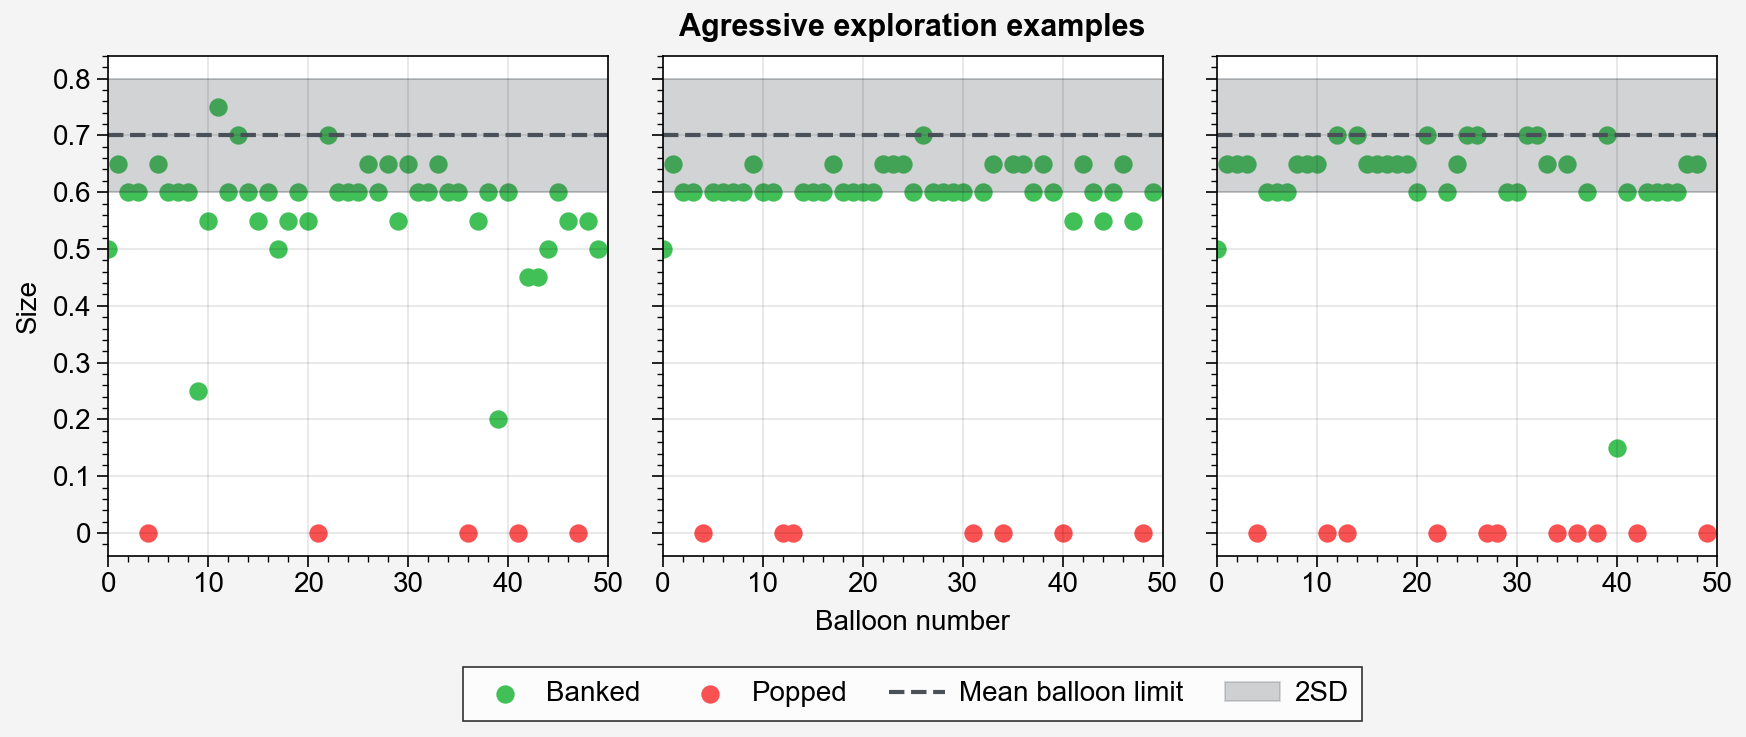

In [86]:
example_idxs = [10, 14, 22]
fig, ax = pplt.subplots(ncols=3)
ep = 10
idxs = select_chks_by_dimension(h=0)
for i, idx in enumerate(example_idxs):
    idx = idxs[idx]
    
    x = np.arange(50)
    it = res['last_sizes'][idx][ep]

    lines = []
    lines.append(ax[i].scatter(x[it != 0], it[it != 0], c='green6', label='Banked'))
    lines.append(ax[i].scatter(x[it == 0], it[it == 0], c='red6', label='Popped'))
    lines.append(ax[i].plot([0, 50], [mus[ep], mus[ep]], c='gray7', linestyle='--', label='Mean balloon limit'))
    lines.append(ax[i].fill_between([0, 50], [mus[ep]-0.1, mus[ep]-0.1], [mus[ep]+0.1, mus[ep]+0.1], label='2SD',
                    c='gray7', alpha=0.25))

fig.legend(lines, loc='b', ncols=4)
ax.format(xlabel='Balloon number', ylabel='Size', suptitle='Agressive exploration examples')

In [393]:
its = res['last_sizes'][idxs[4]]
early_pops = (its[:, :10] == 0).sum(axis=1)
late_pops = (its[:, 10:] == 0).sum(axis=1)
print(early_pops, late_pops)

[6 5 3 5 4 5 3 2 2 0 0 0 0 0 0 0 0] [ 8 12 11 13 13 12 11  6  7  4  0  1  0  0  0  0  0]


### Gradual exploration

Measured as frequency that the agent tends to increase its inflation times. Tendency is how how many episodes this grows by > 0.2 through the episode

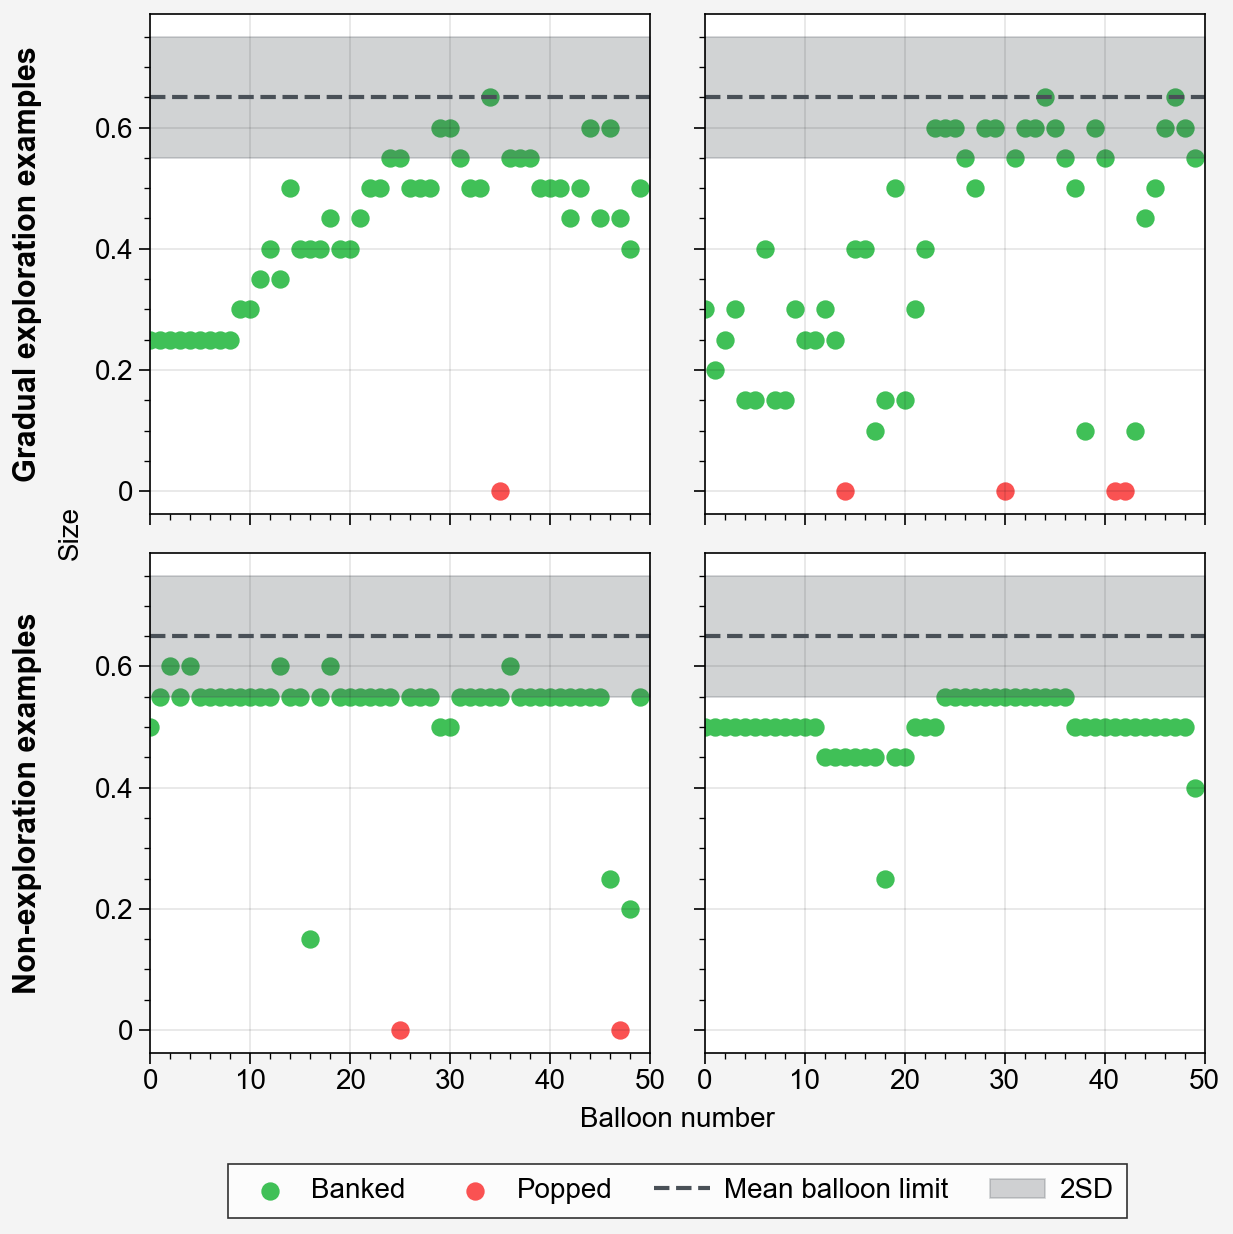

In [ ]:
example_idxs = [0, 24, 3, 56]
fig, ax = pplt.subplots(nrows=2, ncols=2)
ep = 9
idxs = select_chks_by_dimension(h=0)
for i, idx in enumerate(example_idxs):
    idx = idxs[idx]
    
    x = np.arange(50)
    it = res['last_sizes'][idx][ep]

    lines = []
    lines.append(ax[i].scatter(x[it != 0], it[it != 0], c='green6', label='Banked'))
    lines.append(ax[i].scatter(x[it == 0], it[it == 0], c='red6', label='Popped'))
    lines.append(ax[i].plot([0, 50], [mus[ep], mus[ep]], c='gray7', linestyle='--', label='Mean balloon limit'))
    lines.append(ax[i].fill_between([0, 50], [mus[ep]-0.1, mus[ep]-0.1], [mus[ep]+0.1, mus[ep]+0.1], label='2SD',
                    c='gray7', alpha=0.25))

fig.legend(lines, loc='b', ncols=4)
ax.format(xlabel='Balloon number', ylabel='Size', leftlabels=['Gradual exploration examples',
                                                              'Non-exploration examples'])

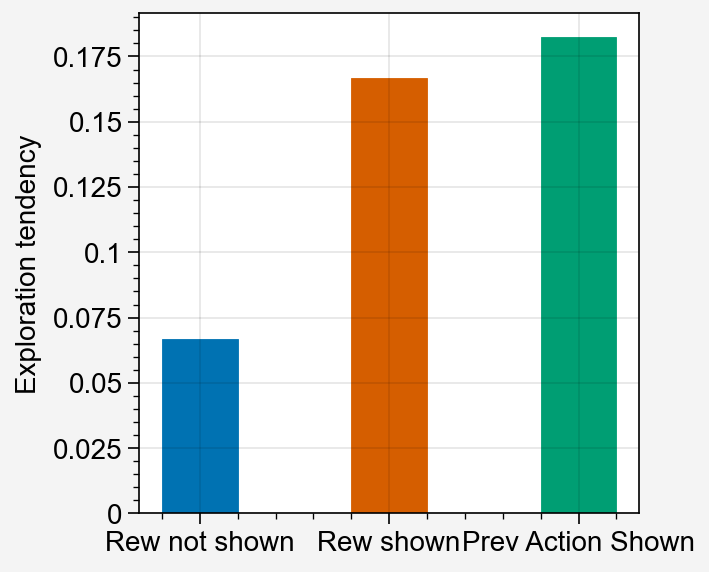

In [21]:
fig, ax = pplt.subplots()

all_expl = []
for h in range(3):
    exploration_tendencies = []
    idxs = select_chks_by_dimension(h=h)

    for idx in idxs:
        diffs = []
        for it in res['unpopped_sizes'][idx]:
            sm_it = pd.Series(it).ewm(alpha=0.1).mean()
            sm_it = np.array(sm_it)
            max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
            diffs.append(max_diff)
        exploration_tendencies.append((np.array(diffs) > 0.2).sum() / 17)
        # exploration_tendencies.append(np.mean(diffs))

    # ax.boxplot(h, exploration_tendencies)
    ax.bar(h, np.mean(exploration_tendencies))
    all_expl.append(exploration_tendencies)
    

ax.format(xlocator=range(3), xformatter=give_labels,
          ylabel='Exploration tendency')

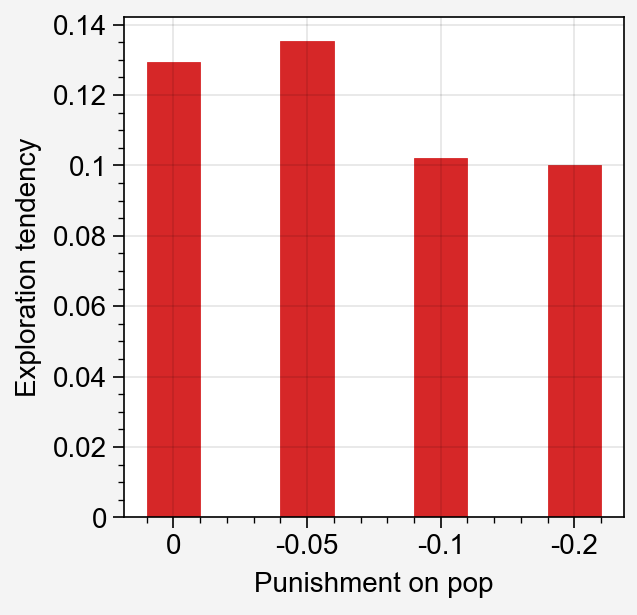

In [79]:
fig, ax = pplt.subplots()

all_expl = []
for i in range(4):
    exploration_tendencies = []
    idxs = select_chks_by_dimension(i=i)

    for idx in idxs:
        diffs = []
        for it in res['unpopped_sizes'][idx]:
            sm_it = pd.Series(it).ewm(alpha=0.1).mean()
            sm_it = np.array(sm_it)
            max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
            diffs.append(max_diff)
        exploration_tendencies.append((np.array(diffs) > 0.2).sum() / 17)
        # exploration_tendencies.append(np.mean(diffs))

    # ax.boxplot(i, exploration_tendencies)
    ax.bar(i, np.mean(exploration_tendencies), c=rgb_colors[3])
    all_expl.append(exploration_tendencies)
    

ax.format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
          ylabel='Exploration tendency')

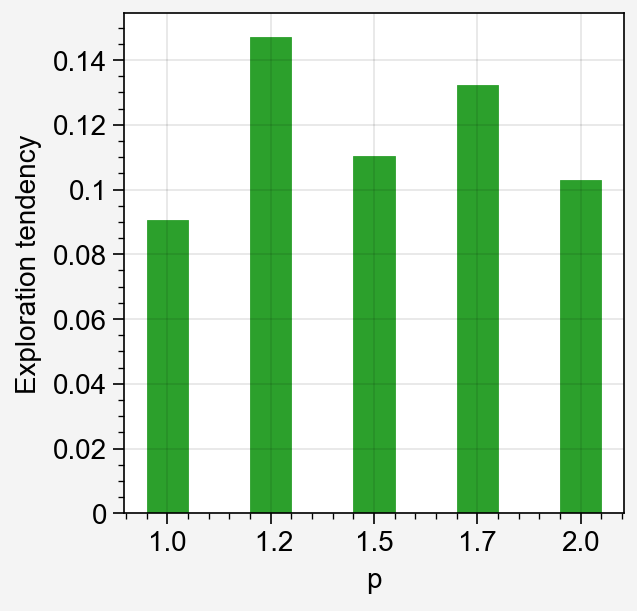

In [78]:
fig, ax = pplt.subplots()

all_expl = []
for j in range(5):
    exploration_tendencies = []
    idxs = select_chks_by_dimension(j=j)

    for idx in idxs:
        diffs = []
        for it in res['unpopped_sizes'][idx]:
            sm_it = pd.Series(it).ewm(alpha=0.1).mean()
            sm_it = np.array(sm_it)
            max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
            diffs.append(max_diff)
        exploration_tendencies.append((np.array(diffs) > 0.2).sum() / 17)
        # exploration_tendencies.append(np.mean(diffs))

    # ax.boxplot(j, exploration_tendencies)
    ax.bar(j, np.mean(exploration_tendencies), c=rgb_colors[2])
    all_expl.append(exploration_tendencies)
    

ax.format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
          ylabel='Exploration tendency')